# Wrangling Challenge: Real Estate Data Compilation and Analysis
#### Author: Siddharth Gupte

Date: 08/06/2022

Version: 1.5

Environment: Python 3.10.4 and Anaconda 4.11.0 (64-bit)

## 1. Introduction

The goal of this activity is to integrate data from different sources and perform operations on it. The sources include different file formats and internet based sources.The data in these sources is basically real estate information for suburbs in Victoria, Australia.

## 2. Loading the Libraries

These are the libraries we are going to require for this integration process. Here is a summary of the libraries being used:

* `Warnings` to hide any Jupyter Notebook kernel warning messages.
* `Pandas` for manipulating the data extracted from the different sources.
* `Numpy` to perform a number of array based operations on the data.
* `BeautifulSoup` to parse the XML file properly.
* `XML.SAX` to check whether the XML file has syntactical issues.
* `Glob` to return the file path of the XML file
* `SYS` to capture the runtime XML parsing error
* `Math` to calculate the haversine distance between the property and the closest station.
* `Re` to capture incorrect time formats in the metropolitan stop time data.
* `Selenium` to web scrape the required data from https://www.yourinvestmentpropertymag.com.au.
* `Camelot` to scan the PDF file and import the tabular data.
* `Shapely` to help match a property point to a suburb polygon 
* `Geopandas` to manipulate the data extracted from a shapefile.
* `Sklearn` to perform different scaling and transformation methods on the web scraped data.
* `Statsmodels` to use the Least Squares method for assessing linearity and outliers.
* `Seaborn` for visualisation of the results of different scaling and transformation methods.
* `Matplotlib` for customising the visualisation of different scaling and transformation methods.

In [1]:
import warnings
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from xml.sax.handler import ContentHandler
from xml.sax import make_parser
from glob import glob
import sys
from math import radians, cos, sin, asin, sqrt
import re
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.service import Service
import camelot as cm
from shapely.geometry import Point, Polygon
import geopandas as gpd
from sklearn import preprocessing
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
# Hiding the Jupyter notebook warnings
warnings.filterwarnings('ignore')

## 3. Data Integration

The first step to integrate the data is gather it from different sources and then finding a common ground to merge them successfully. We have a variety of sources at hand. These are as follows:

* **XML**: 31524923_realstate.xml 
* **PDF**: 31524923_realstate.pdf 
* **GEODATA**: Vic_suburb_boundary (directory)
* **Text**: Vic_GTFS_data (directory)
* https://www.yourinvestmentpropertymag.com.au (website) 

Let us tackle them one by one.

### 3.1 PDF 

We have a file in `.pdf` format. It contains a table with the following columns:

* property_id: A unique ID for the property
* lat: The latitudinal coordinate of the property
* lon: The longitudinal coordinate of the property
* addr_street: The property address

#### 3.1.1 Loading the Data

To import the table in this PDF file, we can use the camelot library as follows:

In [3]:
# Extracting the table using read_pdf 
pdf_tables = cm.read_pdf("31524923_realstate.pdf")

# Checking the number of tables in the pdf file
print("Total tables extracted:", pdf_tables.n)

Total tables extracted: 1


In [4]:
# Transforming the extracted table into a dataframe
real_estate_vic = pdf_tables[0].df

# Checking the new dataframe
real_estate_vic

,0,1,2,3
0,property_id,lat,lng,addr_street
1,93371,-38.012008,145.098148,44 Mount View Street
2,1866,-37.783917,144.870803,169 Ballarat Road
3,74502,-37.903454,145.073528,11 Adams street
4,57514,-37.828885,145.147519,1/6 Molleton Street
...,...,...,...,...
1034,32044,-37.745343,144.98595,17 Matlock Street
1035,58873,-37.814319,145.169649,30 Sandy Street
1036,36528,-37.664135,145.02489599999996,60 Curtin Avenue
1037,69970,-37.86652700000001,145.081251,34 Morotai Avenue


#### 3.1.2 Polishing the Data

Overall, we have around 1040 rows of data in the extracted data. However, we need to do a few things to ensure that the dataset is ready for integration.

* Firstly, we need to set the header row correctly. This will be integral in helping us identify the columns in this data with the data extracted from other sources.
* Secondly, we need to observe the the columns in the data and see what kind of information is contained in it. This is to make sure that there is nothing in the data which is out of the ordinary or does not make semantic sense.

In [5]:
# Setting the header row correctly for the column names
header = real_estate_vic.iloc[0] #grab the first row for the header

# Grab the data without its current header
real_estate_vic = real_estate_vic[1:] 

# Attaching the new header to the dataframe
real_estate_vic.columns = header

# Resetting the dataframe index
real_estate_vic = real_estate_vic.reset_index(drop=True)

# Checking whether the header has been set correctly
real_estate_vic.head(5)

,property_id,lat,lng,addr_street
0,93371,-38.012008,145.098148,44 Mount View Street
1,1866,-37.783917,144.870803,169 Ballarat Road
2,74502,-37.903454,145.073528,11 Adams street
3,57514,-37.828885,145.147519,1/6 Molleton Street
4,38719,-37.762538,145.042072,20 Bond Street


Before we finalise this data, let us observe it closely.

In [6]:
# Let us look at information about the data which has been extracted from the PDF file
real_estate_vic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  1038 non-null   object
 1   lat          1038 non-null   object
 2   lng          1038 non-null   object
 3   addr_street  1038 non-null   object
dtypes: object(4)
memory usage: 32.6+ KB


#### 3.1.3 Observations and Actions

The above information shows us that there are no null values in the data. Secondly, we can see that the datatype for all 4 columns is Object. 

However, if we consider the subset of the data on display above, we can see that three of the columns may have numeric or floating values. We must change the data type of these columns to their respective datatypes. We can leave the datatype of the `addr_street` column as it is.

If there are no other issues in the data, the datatype conversion process will not throw us any errors.

In [7]:
# Checking if all values in the property_id column are numeric
pd.to_numeric(real_estate_vic['property_id'], errors='coerce').notnull().all()

True

In [8]:
# Converting datatype of the columns 
real_estate_vic["property_id"] = pd.to_numeric(real_estate_vic['property_id'])
real_estate_vic['lat'] = real_estate_vic['lat'].astype(float)
real_estate_vic['lng'] = real_estate_vic['lng'].astype(float)

In [9]:
# Checking the converted datatypes:
real_estate_vic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   property_id  1038 non-null   int64  
 1   lat          1038 non-null   float64
 2   lng          1038 non-null   float64
 3   addr_street  1038 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.6+ KB


We now have three different datatypes in the data. Let us describe the data:

In [10]:
# Describing the numeric columns
real_estate_vic.describe()

,property_id,lat,lng
count,1038.000000,1038.000000,1038.000000
mean,49589.613680,-37.807822,145.049622
std,27504.458435,0.098574,0.135749
min,44.000000,-38.075097,144.637947
25%,25716.000000,-37.865964,144.967994
50%,50037.500000,-37.805204,145.042474
75%,73115.500000,-37.737051,145.139836
max,96899.000000,-37.574863,145.370016


In [11]:
# Describing the non-numeric columns
real_estate_vic.addr_street.describe()

count                 1038
unique                1028
top       42 Hawthory Road
freq                     2
Name: addr_street, dtype: object

The describe function does not point out any obvious anomalies in the data. Additionally, we don't have any additional information that can help validate the data on a semantic level. Therefore, we can proceed with the assumption that the data is correct and move to the XML data.

### 3.2 XML 

Our second file in `.xml` format. Let us load the file and have a look at it before we can attempt to parse it for data.

In [14]:
# Reading the file
test_xml = open("31524923_realstate.xml")

# Specifying the number of lines
lines = 10

# Printing the lines
for i in range(lines):

    line = test_xml.readline()
    print(line)

# Closing the file
test_xml.close()

<property>

  <property_id>32044</property_id>

  <lat>-37.745343</lat>

  <lng>144.98595</lng>

  <addr_street>17 Matlock Street</addr_street>

</property>

<property>

  <property_id>58873</property_id>

  <lat>-37.814319</lat>

  <lng>145.169649</lng>



We can see that the file specifies the following tags, each of which may contain some data:

* property_id: A unique ID for the property
* lat: The latitudinal coordinate of the property
* lon: The longitudinal coordinate of the property
* addr_street: The property address

If we take a look at the above tags, we can see that they correspond to the column names we finalised for the dataset extracted from the `.pdf` file. We must maintain this naming convention to bring about a commonality for integrating the data.

#### 3.2.1 Loading the Data

XML files are not always reliable in terms of their syntactical completeness. There might be different kinds of syntactical anomalies in an XML file. We can use the xml.sax library in Python to check whether there are any issues in it.

In [15]:
# Function to parse the XML file
def xmlparser(filename):
    parser = make_parser(  )
    parser.setContentHandler(ContentHandler(  ))
    parser.parse(filename)

# Accessing the runtime response for the result of the XML validation
for arg in sys.argv[1:]:
    for filename in glob(arg):
        try:
            xmlparser("31524923_realstate.xml")
            print ("%s is a valid XML." % "31524923_realstate.xml")
        except :
            print ("%s is not a valid XML." % ("31524923_realstate.xml"))

31524923_realstate.xml is not a valid XML.


It looks like the XML file contains some syntactical errors. This poses a problem as conventional XML parsing libraries like Elementree will not be able to parse an invalid XML file. We can use the `BeautifulSoup` library instead.

This is because we already know that the data we want is contained in four specific tags.

To extract the data from this XML file in a proper manner, we can use the `BeautifulSoup` library with an `lxml` parsing engine. `lxml` provides a more powerful parsing functionality which encompasses different types of XML files. The benefit of using this method is that any kind of syntactical anomalies in the XML file are gracefully skipped while the specific data which is in between the valid tags is extracted.

Note: `lxml` must be installed via pip or conda prior to running the below operation.

In [16]:
# Opening the XML file for reading
estate_xml = open("31524923_realstate.xml",'r')
tags = estate_xml.read()

# Parsing the file content
soup_it = BeautifulSoup(tags,'lxml')

# Extracting the specific data we want
property_ids = soup_it.find_all('property_id')
lats = soup_it.find_all('lat')
lngs = soup_it.find_all('lng')
streets = soup_it.find_all('addr_street')

# Putting the data into a list of lists
data = []
for i in range(0,len(property_ids)):
    rows = [property_ids[i].get_text(),lats[i].get_text(),
           lngs[i].get_text(),streets[i].get_text()]
    data.append(rows)

# Converting the list of lists into a dataframe with proper column names
real_estate2 = pd.DataFrame(data, columns = ['property_id','lat',
                                  'lng','addr_street'], dtype = float)
# Checking the dataframe
real_estate2

,property_id,lat,lng,addr_street
0,32044.0,-37.745343,144.985950,17 Matlock Street
1,58873.0,-37.814319,145.169649,30 Sandy Street
2,36528.0,-37.664135,145.024896,60 Curtin Avenue
3,69970.0,-37.866527,145.081251,34 Morotai Avenue
4,64587.0,-37.799186,145.277344,5 Lemnos Street
...,...,...,...,...
1038,77601.0,-37.925884,145.198082,18 Sneddon Court
1039,54450.0,-37.822804,145.023722,36 Morang Road
1040,80708.0,-38.000393,145.208811,101 Hammond Road
1041,4373.0,-37.847817,144.864355,32 Rosshire Road


#### 3.2.2 Polishing the Data

We can follow a similar process of checking and polishing any discrepancies we see in the data. As always, we can start with using the `.info()` function.

In [17]:
# Getting information about the data
real_estate2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   property_id  1043 non-null   float64
 1   lat          1043 non-null   float64
 2   lng          1043 non-null   float64
 3   addr_street  1043 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB


#### 3.2.3 Observations and Actions
It seems that the extraction process has converted the values of the column `property_id` into floating point numbers. Therefore, we can convert the datatype of this column into a numeric form. The goal is to bring the format and look of this data to that of the PDF extracted data.

In [18]:
# Checking the `property_id` column for any non-numeric values
pd.to_numeric(real_estate2['property_id'], errors='coerce').notnull().all()

True

In [19]:
# Converting the property_id column to numeric datatype
real_estate2["property_id"] = real_estate2['property_id'].astype(int)

# Checking the column
real_estate2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   property_id  1043 non-null   int64  
 1   lat          1043 non-null   float64
 2   lng          1043 non-null   float64
 3   addr_street  1043 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB


Next, we can use the `.describe()` function to find any anomalies in the data.

In [20]:
# Describing the numeric and floating point columns
real_estate2.describe()

,property_id,lat,lng
count,1043.000000,1043.000000,1043.000000
mean,48167.358581,-37.806823,145.041017
std,28042.021884,0.097900,0.131773
min,83.000000,-38.076265,144.636821
25%,24533.000000,-37.867081,144.956520
50%,47388.000000,-37.803066,145.037007
75%,72662.500000,-37.738068,145.110205
max,97086.000000,-37.574651,145.370145


In [21]:
# Describing the object datatype column
real_estate2.addr_street.describe()

count                1043
unique               1036
top       86 Union Street
freq                    2
Name: addr_street, dtype: object

As with the first dataset, the `.describe` function does not tell us anything anomalous about the dataset. Therefore, we can proceed and combine the two datasets together.

#### 3.2.4 Combining the PDF and XML Data

While combining the two datasets real_estate_vic and real_estate2, we must determine the type of methodology to be used to combine them. For example, if the two dataframes contain rows which are exactly the same or have the same property id values, a concatenation operation would ensure duplicate rows of the data.

In [65]:
# Adding the two dataframes in a list
concat1 = [real_estate_vic, real_estate2]

# Concatenating the two dataframes into one
real_estate_integrated = pd.concat(concat1)

# Resetting the index
real_estate_integrated.reset_index(drop = True, inplace = True)

In [66]:
# Checking the integrated dataframe
real_estate_integrated

,property_id,lat,lng,addr_street
0,93371,-38.012008,145.098148,44 Mount View Street
1,1866,-37.783917,144.870803,169 Ballarat Road
2,74502,-37.903454,145.073528,11 Adams street
3,57514,-37.828885,145.147519,1/6 Molleton Street
4,38719,-37.762538,145.042072,20 Bond Street
...,...,...,...,...
2076,77601,-37.925884,145.198082,18 Sneddon Court
2077,54450,-37.822804,145.023722,36 Morang Road
2078,80708,-38.000393,145.208811,101 Hammond Road
2079,4373,-37.847817,144.864355,32 Rosshire Road


#### 3.2.5 Duplicate Row Check

We can see that the rows of the two dataframes have been properly concatenated. Let us first check this new dataframe for duplicate rows.

In [67]:
# Checking for duplicate rows
real_estate_integrated[real_estate_integrated.duplicated()]

,property_id,lat,lng,addr_street
443,55514,-37.838091,145.059148,30 Sunnyside Avenue
600,55692,-37.841900,145.085589,44 Lynden Street
607,9501,-37.854182,144.724546,36 Ronald Road
613,49454,-37.806844,145.078618,38 Frederick Street
796,45956,-37.719136,145.119526,20 Nokes Court
827,33885,-37.719563,145.002564,15 Henty Street
868,30846,-37.755825,145.019113,173 Collins Street
941,4271,-37.844666,144.865463,"217 Woods Street,"
987,65371,-37.798037,145.313479,42 Hawthory Road
1038,32044,-37.745343,144.985950,17 Matlock Street


The concatenated dataset has a number of duplicate rows. we can remove these rows now. We can use the `.drop_duplicates` function from the Pandas library to do this.

In [68]:
# Removing the duplicates from the data
real_estate_integrated.drop_duplicates(inplace=True)

# Resetting the index 
real_estate_integrated.reset_index(drop = True, inplace = True)

# Checking the new row count
len(real_estate_integrated)

2048

We have successfully combined the first two datasets from two different sources. We can now move on to the other sources.

### 3.3 Shape File Integration

We have two shape file directory which contains information about the suburbs in Victoria. More specifically, these files contain information marking the boundary of each suburb in Victoria. The provided directory of the shape files `vic_suburb_bounadry` contains the following files:

* `VIC_LOCALITY_POLYGON_shp.dbf`
* `VIC_LOCALITY_POLYGON_shp.prj`
* `VIC_LOCALITY_POLYGON_shp.shp`
* `VIC_LOCALITY_POLYGON_shp.shx`
* `vic_suburbs.json`

Based on the given files, it looks like the Victoria suburban boundary data follows the structure of a shapefile directory except for the `.json` file. The general structure of a shapefile directory is such that the `.shp` file contains the latitudinal and longitudinal information about the locations. The `.dbf` file is the data storage container for storing information about the locations at the coordinates mentioned in the `.shp` file. 

To integrate this data with the main dataset, we must align it such that the properties listed in the main dataset are assigned the correct suburb based on their latitudinal and longitudinal coordinates. 

Therefore, let us start by loading and observing the shape information of the suburbs in the `.shp` file because it is the obvious choice. If luck holds, this file will contain all the information we need to capture the suburb names and we won't need the other files.

We can use the `geopandas` library to do this.

In [69]:
# Viewing the .shp file with geopandas
geojson1 = gpd.GeoDataFrame.from_file('vic_suburb_bounadry/VIC_LOCALITY_POLYGON_shp.shp')

# Viewing the geojson dataset
geojson1

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92288 -37.97886, 142.90449 -37.9..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82336 -37.66001, 147.82313 -37.6..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.27978 -35.99859, 141.27989 -35.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,10667,2017-06-02,None,VIC1635,2017-08-09,None,MELBOURNE AIRPORT,None,None,G,None,2,"POLYGON ((144.86382 -37.67087, 144.86405 -37.6..."
2969,10666,2017-06-02,None,VIC381,2017-08-09,None,BULLA,None,None,G,None,2,"POLYGON ((144.80217 -37.66167, 144.80243 -37.6..."
2970,10688,2017-06-02,None,VIC2308,2017-08-09,None,SOMERS,None,None,G,None,2,"POLYGON ((145.19211 -38.39105, 145.19392 -38.3..."
2971,10687,2017-06-02,None,VIC1187,2017-08-09,None,HMAS CERBERUS,None,None,G,None,2,"POLYGON ((145.21831 -38.38722, 145.21863 -38.3..."


#### 3.3.1 Observing the Shape File

If we observe the column names for the shape file marked with the `.shp` extension in the local directory, it is a tradional Geopandas dataframe with all the required columns including the geometry column. The geometry column contains the coordinate information of each suburb stored as polygons. The column names are in uppercase form.

The names of the suburbs seem to be contained in a column called `vic_loc_2` on first glance. However, there are several other columns in this dataset. We need to make sure that they do not contain any information that is needed to acquire the right suburbs for the main property dataset. We can start by using the `.info()` function.

Before we check the data, let us change the case of the column names for code consistency. Let us make them lowercase as follows:

In [70]:
# Converting the column names of geojson2 into lowercase
geojson1.columns = geojson1.columns.str.lower()

# Checking the column names
geojson1.columns

Index(['lc_ply_pid', 'dt_create', 'dt_retire', 'loc_pid', 'vic_locali',
       'vic_loca_1', 'vic_loca_2', 'vic_loca_3', 'vic_loca_4', 'vic_loca_5',
       'vic_loca_6', 'vic_loca_7', 'geometry'],
      dtype='object')

In [71]:
# Checking the different columns and their datatypes
geojson1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2973 entries, 0 to 2972
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lc_ply_pid  2973 non-null   object  
 1   dt_create   2973 non-null   object  
 2   dt_retire   0 non-null      object  
 3   loc_pid     2973 non-null   object  
 4   vic_locali  2973 non-null   object  
 5   vic_loca_1  0 non-null      object  
 6   vic_loca_2  2973 non-null   object  
 7   vic_loca_3  0 non-null      object  
 8   vic_loca_4  31 non-null     object  
 9   vic_loca_5  2973 non-null   object  
 10  vic_loca_6  0 non-null      object  
 11  vic_loca_7  2973 non-null   object  
 12  geometry    2973 non-null   geometry
dtypes: geometry(1), object(12)
memory usage: 302.1+ KB


We can see that there are several columns which have NULL values in them. For the columns which don't have any Non-null values, we can ignore them completely. Our `vic_loca_2` is completely populated and that is a good sign. There are 2973 non-null values in this column. Secondly, we seem to be having some non-null values in the `vic_loca_4` column. Let us check a few of them. 

First, let us observe the `vic_loca_2` column.

In [72]:
#Checking the vic_loca_2 column
geojson1.vic_loca_2.value_counts()

GOLDEN POINT    3
BELLFIELD       2
HILLSIDE        2
BIG HILL        2
ASCOT           2
               ..
HOMEBUSH        1
MARSHALL        1
HAVEN           1
LOWER NORTON    1
GLEN ALVIE      1
Name: vic_loca_2, Length: 2957, dtype: int64

It seems that a few of the suburbs have more than one entry. This is unusual and so we must explore this further.

In [73]:
# Creating a dataframe of the value counts
geo_values = geojson1.vic_loca_2.value_counts().to_frame()

# Checking the suburbs which have more than one entry
geo_values[geo_values['vic_loca_2'] > 1]

,vic_loca_2
GOLDEN POINT,3
BELLFIELD,2
HILLSIDE,2
BIG HILL,2
ASCOT,2
HAPPY VALLEY,2
STONY CREEK,2
THOMSON,2
NEWTOWN,2
MYALL,2


This is the set of suburbs which have more than one entry in the data. Let us observe the data for one of these suburbs. 

In [74]:
# Checking the data for the suburb Golden Point
geojson1[geojson1['vic_loca_2'] == 'GOLDEN POINT']

,lc_ply_pid,dt_create,dt_retire,loc_pid,vic_locali,vic_loca_1,vic_loca_2,vic_loca_3,vic_loca_4,vic_loca_5,vic_loca_6,vic_loca_7,geometry
476,6794,2011-08-31,None,VIC2979,2012-04-27,None,GOLDEN POINT,None,3465,G,None,2,"POLYGON ((143.76022 -37.09973, 143.76082 -37.0..."
497,6867,2011-08-31,None,VIC2977,2012-04-27,None,GOLDEN POINT,None,3350,G,None,2,"POLYGON ((143.85456 -37.57172, 143.85792 -37.5..."
805,7300,2011-08-31,None,VIC2978,2012-04-27,None,GOLDEN POINT,None,3451,G,None,2,"POLYGON ((144.25641 -37.05765, 144.26048 -37.0..."


The above data shows that Golden Point has three different Polygons in the `geometry` column and three different pincodes in the `vic_loca_4` column. If we look this up online on https://postcodes-australia.com/areas/vic/country+victoria/golden+point, we can confirm that it is normal for a suburb to have more than one pincode if it is covering a large area. We can proceed accordingly.

In [75]:
# Checking the vic_loca_4 column
geojson1.vic_loca_4.unique()

array([None, '3691', '3219', '3450', '3312', '3465', '3350', '3231',
       '3451', '3555', '3360', '3364', '3875', '3533', '3544', '3825',
       '3723', '3220', '3434', '3081', '3381', '3371', '3579', '3549',
       '3561', '3957', '3037', '3351', '3551'], dtype=object)

On observing the `vic_loca_4` column, we can see the list of unique pincodes. Some suburbs don't have a pincode and are marked as `None`. As confirmed in the post https://edstem.org/au/courses/8112/discussion/882193, we do not need to concern ourselves with the pincode as we have our suburb names.

In [76]:
# Checking the vic_loca_7 column
geojson1.vic_loca_7.unique()

array(['2'], dtype=object)

In [77]:
# Checking a random suburb polygon
geojson1.loc[geojson1['vic_loca_2'] == 'SOMERS', 'geometry']

2970    POLYGON ((145.19211 -38.39105, 145.19392 -38.3...
Name: geometry, dtype: geometry

Since we have imported a shape file for the suburbs in Victoria, let us plot a map of the suburbs from the information about the polygons in the data. 

<AxesSubplot:>

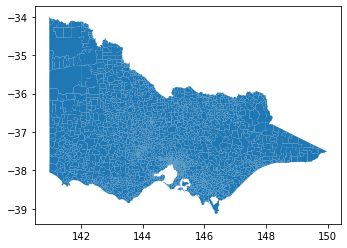

In [78]:
# Plotting the shapefile.
geojson1.plot()

We can see that the shape data has properly rendered a map of Victoria. Based on these observations, we can conclude that `geometry` and `vic_loca_2` are the two columns of interest. We can use these columns to add the suburb names to the main property dataset. If we don't get some relevant matches for the property coordinates in the main dataframe to specific suburbs, we may have to look at the other files in the shape file directory.

#### 3.3.2 Creating the Suburbs column in the Real Estate Dataset

To add the suburbs to the main dataset, we must use the point coordinates inside that dataset and map them to fit in one of the polygon coordinates in the shapefile data. We can use the `.sjoin` function of the `GeoPandas` library. This entire process will follow the below steps:

* Note the coordinate reference system code for the suburbs polygon data
* Combine the latitude and longitudinal coordinates in the property data into a list called geometry, which includes each pair of coordinates as a point.
* Convert the original dataframe into a GeoPandas dataframe, using the same CRS code for the points as the suburb polygons and passing the geometry list as a column.
* Perform a spatial join between this newely converted Geopandas dataframe with the shapefile data using the `sjoin()` function. This function maps points to their rightful polygons. This will be a left join as we want all the property point coordinates, irrespective of whether there is a suburb polygon they can fit into. For the proprties which don't have a suburb in the shapefile data, the right table columns will be NULL. We must also specify the `vic_loca_2` column here as that is the one we are interested in from the shapefile data.
* Check for NULL values for the suburb names in the newly combined dataframe and replace them with `not available` if any.
* Convert this combined dataframe back into a regular pandas dataframe.
* Rename the `vic_loca_2` column to `suburb`.
* Remove the extra columns `geometry` and `index_right`.

In [79]:
# Noting the CRS code for the shapefile data
geojson1.crs  

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.55, 173.34, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [80]:
# Creating a list of coordinate points for the properties
geometry = [Point(xy) for xy in zip(real_estate_integrated.lng, real_estate_integrated.lat)]

# Converting the original dataframe into a GeoDataframe
real_estate_integrated = gpd.GeoDataFrame(real_estate_integrated, crs = "EPSG:4283", geometry = geometry)

In [81]:
# Joining the dataframe with the shapefile data with a left join
real_estate_integrated = gpd.sjoin(real_estate_integrated, 
                                         geojson1[['vic_loca_2', 'geometry']], how = "left")

# Checking the newly combined dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,geometry,index_right,vic_loca_2
0,93371,-38.012008,145.098148,44 Mount View Street,POINT (145.09815 -38.01201),565,ASPENDALE
1,1866,-37.783917,144.870803,169 Ballarat Road,POINT (144.87080 -37.78392),394,MAIDSTONE
2,74502,-37.903454,145.073528,11 Adams street,POINT (145.07353 -37.90345),629,MURRUMBEENA
3,57514,-37.828885,145.147519,1/6 Molleton Street,POINT (145.14752 -37.82888),867,BLACKBURN
4,38719,-37.762538,145.042072,20 Bond Street,POINT (145.04207 -37.76254),2495,IVANHOE
...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,POINT (145.19808 -37.92588),2907,MULGRAVE
2044,54450,-37.822804,145.023722,36 Morang Road,POINT (145.02372 -37.82280),671,HAWTHORN
2045,80708,-38.000393,145.208811,101 Hammond Road,POINT (145.20881 -38.00039),282,DANDENONG
2046,4373,-37.847817,144.864355,32 Rosshire Road,POINT (144.86436 -37.84782),585,NEWPORT


In [82]:
# Checking for null values in the vic_loca_2 column
pd.isnull(real_estate_integrated["vic_loca_2"]).any()

False

It looks like every property in the main dataframe has found a suburb. Therefore, we can finalise this data and not worry about the other files in the shapefile directory.

In [83]:
# Converting the dataframe back into a regular Pandas dataframe
real_estate_integrated = pd.DataFrame(real_estate_integrated)

In [84]:
# Renaming the vic_loca_2 column
real_estate_integrated.rename(columns = {'vic_loca_2':'suburb'}, inplace = True)

# Checking the column name
real_estate_integrated.columns

Index(['property_id', 'lat', 'lng', 'addr_street', 'geometry', 'index_right',
       'suburb'],
      dtype='object')

In [85]:
# Removing the geometry and index right columns
real_estate_integrated.drop(['geometry', 'index_right'], axis = 1, inplace = True)

# Checking the data
real_estate_integrated.head(4)

,property_id,lat,lng,addr_street,suburb
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN


In [86]:
# Checking if there are NULL values in `suburb`
real_estate_integrated['suburb'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2048 entries, 0 to 2047
Series name: suburb
Non-Null Count  Dtype 
--------------  ----- 
2048 non-null   object
dtypes: object(1)
memory usage: 32.0+ KB


Since we have a non-null `suburb` value for every property in the data, we do not need to check the other files in the shapefile directory. 

### 3.4 Closest Train Stations

In this step, we must find information about the closest train station for each of these addresses. We have been provided with a `Vic_GTFS_data` datastore, which contains a lot of the metropolitan information about Victoria. We have to use this data somehow to calculate the closest train station for each property.

#### 3.4.1 Creating the Columns

First, we can create a new column in the main integrated data frame. The name of this column is `distance_to_closest_train_station`.

In [87]:
# Creating an empty column for the closest train station distance in the main dataframe
real_estate_integrated['distance_to_closest_train_station'] = 0


# Checking the columns
real_estate_integrated.head(3)

,property_id,lat,lng,addr_street,suburb,distance_to_closest_train_station
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,0
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,0
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,0


#### 3.4.2 Observing the data in `stops.txt`

We have been given a directory of text files which contain metropolitan information about Victoria. This information follows a standard format called GTFS (General Transit Feed System). If we take a look at the information given here [GTFS](https://en.wikipedia.org/wiki/General_Transit_Feed_Specification), the data contained in the `stops` dataset will contain the names of all the railway stations.

In the given directory, `stops.txt` file contains information about the different train stations and their coordinates. We can use this file to calculate the Haversine distance between these stops and each of the train stations. After we have calculated the Haversine distance, we can find the shortest distance and store the stop_id and the distance in the main dataframe.

We can use the `.read_csv()` function to load the data inside the text file `stops.txt` by specifying the delimiter as `,`. Once we have loaded the data, we can observe it and its columns.

In [88]:
# Reading the stops file
stops_df = pd.read_csv("Vic_GTFS_data/metropolitan/stops.txt", sep = ",")

# Checking the imported dataframe
stops_df.head(5)

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602


In [89]:
# Observing the size of the data
stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stop_id          218 non-null    int64  
 1   stop_name        218 non-null    object 
 2   stop_short_name  218 non-null    object 
 3   stop_lat         218 non-null    float64
 4   stop_lon         218 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 8.6+ KB


In [90]:
# Observing the unique counts
stops_df.stop_id.nunique()

218

We can see that every row in this dataset is unique. We have around 218 unique `stop_id` values. Therefore, we have coordinates for each of these stop ids. We must calculate the distance between every coordinate point in the original dataframe with every coordinate point in this one to calculate the shortest distance. 

#### 3.4.3 Calculating the Distance

The Haversine formula describes the distance between two points on the earth, given their latitude and longitude. It provides an approximation of the distance by assuming the shape of the earth as a sphere rather than its actual shape. 

Therefore, it is more acccurate for shorter distances such as the distance between a property and the nearest train station. It is the most suitable formula to be applied in this case.

When we express the haversine function as a trignometric function, we do so as follows:

$$
  haversine( \theta ) = sin^2( \frac {\theta}{2})
$$

In terms of d and r where d is the distance between two points and r is the radius of the earth, the haversine formula can be expressed as:

$$
  d=2rsin^{-1} ( \sqrt{sin^{2}(\frac{\Phi_{2} - \Phi_{1}}{2} )+cos(\Phi_{1})cos(\Phi_{2})sin^{2}( \frac{ \lambda_{2}-\lambda_{1}}{2})})
$$

We can use this formula to calculate the distance from each property to its closest station.

In [91]:
# Function to calculate the distance between the property and the nearest station using the Haversine formula
# Reference: https://www.geeksforgeeks.org/program-distance-two-points-earth/
def haver_dist(f_lat, f_lon, t_lat, t_lon):

    # Using the radians function from the math module to convert degrees to radians for each coordinate
    f_lat = radians(f_lat)
    f_lon = radians(f_lon)
    t_lat = radians(t_lat)
    t_lon = radians(t_lon)
    
    # Difference between radians
    lat_diff = t_lat - f_lat
    lon_diff = t_lon - f_lon
    
    # Writing the Haversine formula
    step1 = sin(lat_diff / 2)**2 + cos(f_lat) * cos(t_lat) * sin(lon_diff / 2)**2
    
    # Using inverse sin of the result of the previous step
    step2 = 2 * asin(sqrt(step1))

    # Declaring the radius of the earth in kms
    radius = 6378

    # Returning the final distance with respect to the radius of the earth
    return(step2 * radius)

Since we need to find the shortest distance, we need to calculate the distance from every property to every stop. We can set it up by performing a cross join between the main dataframe and the coordinate data extracted from the `stops.txt` file.

In [92]:
# Merging the main dataframe with all the train station data
prop_stop_merge = pd.merge(real_estate_integrated, stops_df, how = "cross", suffixes = 
                           ('_property', '_station'))

# Checking the cross-joined dataframe
prop_stop_merge

,property_id,lat,lng,addr_street,suburb,distance_to_closest_train_station,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,0,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,0,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,0,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,0,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602
...,...,...,...,...,...,...,...,...,...,...,...
446459,78953,-37.937313,145.165492,31 Grace Street,SPRINGVALE,0,44817,Coolaroo Railway Station,Coolaroo,-37.661003,144.926056
446460,78953,-37.937313,145.165492,31 Grace Street,SPRINGVALE,0,45793,Lynbrook Railway Station,Lynbrook,-38.057341,145.249275
446461,78953,-37.937313,145.165492,31 Grace Street,SPRINGVALE,0,45794,Cardinia Road Railway Station,Pakenham,-38.071290,145.437791
446462,78953,-37.937313,145.165492,31 Grace Street,SPRINGVALE,0,45795,South Morang Railway Station,South Morang,-37.649159,145.067032


In [93]:
# Calling the haversine distance function on the cross join columns 
prop_stop_merge['distance_to_closest_train_station'] = \
np.vectorize(haver_dist)(prop_stop_merge['lat'], 
                         prop_stop_merge['lng'], 
                         prop_stop_merge['stop_lat'], 
                         prop_stop_merge['stop_lon'])

# Checking the calculated distances 
prop_stop_merge.head(10)

,property_id,lat,lng,addr_street,suburb,distance_to_closest_train_station,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,58.192616,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,54.247598,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,41.748814,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,40.493276,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,38.905129,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602
5,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,36.888952,19830,Bittern Railway Station,Bittern,-38.337390,145.178027
6,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,33.580183,19831,Hastings Railway Station,Hastings,-38.305659,145.185980
7,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,28.646960,19832,Tyabb Railway Station,Tyabb,-38.259815,145.186401
8,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,24.713003,19833,Somerville Railway Station,Somerville,-38.225342,145.176245
9,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,20.987374,19834,Baxter Railway Station,Baxter,-38.194043,145.160526


To find the shortest distance for each property, we can aggregate and find the minimum `distance_to_closest_train_station` value for that property. After that we can join this aggregated data with the main dataframe with an inner join.

In [94]:
# Creating a test dataset for shortest distances 
test = prop_stop_merge.groupby(['property_id'])\
                         .agg({'distance_to_closest_train_station':['min']})

# Changing the name of the aggregated column to match that of the main cross joined dataframe
test.columns = ['distance_to_closest_train_station']

# Resetting the index
test = test.reset_index()

# Observing the aggregated dataset
test

,property_id,distance_to_closest_train_station
0,44,0.213859
1,83,0.999335
2,94,0.405704
3,140,0.414715
4,337,0.461131
...,...,...
2043,96812,0.913288
2044,96886,2.230077
2045,96887,1.220955
2046,96899,2.084411


In [95]:
# Performing an inner join to have only those stations that are the closest to some property
real_estate_integrated = pd.merge(prop_stop_merge, test,
                                  on = ['property_id','distance_to_closest_train_station'], how = 'inner')

# Checking the dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,distance_to_closest_train_station,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,1.100446,19863,Mordialloc Railway Station,Mordialloc,-38.006583,145.087659
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,1.841583,20022,Tottenham Railway Station,West Footscray,-37.799251,144.862945
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,1.020205,19918,Hughesdale Railway Station,Hughesdale,-37.894881,145.077635
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,1.005395,19898,Blackburn Railway Station,Blackburn,-37.820071,145.150014
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,0.766879,19933,Ivanhoe Railway Station,Ivanhoe,-37.768897,145.045425
...,...,...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,4.604153,19891,Sandown Park Railway Station,Springvale,-37.956505,145.162826
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,0.130742,19905,Hawthorn Railway Station,Hawthorn,-37.821826,145.022899
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,1.163259,19888,Dandenong Railway Station,Dandenong,-37.989968,145.209725
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,1.784400,19994,Newport Railway Station,Newport,-37.842718,144.883600


#### 3.4.4 Cleaning Up

We have successfully managed to find the stations with the closest distance from each of our properties. Let us do some cleaning up here before moving on with the integration process. 

* Firstly, we can remove all of the unimportant columns like `stop_name` and `stop_short_name`. 
* Even though we don't need the `stop_lat` and `stop_lon` columns in the final integrated dataset, we may require them for calculating the routes to Melbourne Central Station in the next step. Therefore, we can keep them for the time being.
* We need to switch up the index position of the stop_id column and rename it as closest_train_station_id
* Finally, we can change the name of the `stop_id` column to `closest_train_station_id`.

In [96]:
# Assigning the two column names to a list
col_list = list(real_estate_integrated.columns)

# Capturing the index of the two columns
idx1, idx2 = col_list.index('distance_to_closest_train_station'), col_list.index('stop_id')
col_list[idx2], col_list[idx1] = col_list[idx1], col_list[idx2]

# Finalising the index switch
real_estate_integrated = real_estate_integrated[col_list]

# Dropping the unimportant columns
real_estate_integrated.drop(['stop_name', 'stop_short_name'], axis = 1, inplace = True)

# Renaming the stop_id column
real_estate_integrated.rename(columns = {'stop_id':'closest_train_station_id'}, inplace = True)

# Checking the cleaned final dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,stop_lat,stop_lon
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,-38.006583,145.087659
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,-37.799251,144.862945
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,-37.894881,145.077635
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,-37.820071,145.150014
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,-37.768897,145.045425
...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,-37.956505,145.162826
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,-37.821826,145.022899
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,-37.989968,145.209725
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,-37.842718,144.883600


### 3.5 Time to Melbourne Central

The next step in this integration process involves capturing the rounded average travel time to Melbourne Central Station for direct journeys on weekdays. We need to access the metropolitan data for Victoria to perform this calculation. We have been given the following files:

* `stop_times.txt`
* `routes.txt`
* `trips.txt`
* `calendar.txt`
* `calendar_dates`
* `agency.txt`
* `stops.txt`
* `shapes.txt`

As mentioned earlier, the metropolitan data for Victoria follows the GTFS(General Transit Feed Specification) format. More information about this standard format can be found on https://en.wikipedia.org/wiki/General_Transit_Feed_Specification.

The datasets in this format are linked to each other by referential integrity constraints with the ER diagram given here: https://en.wikipedia.org/wiki/General_Transit_Feed_Specification#/media/File:GTFS_class_diagram.svg

Based on the relationships given in this ER diagram, we need to filter and join these datasets to get the information we want as follows:

* Firstly, we need to find the services which run on weekdays. This information can be filtered out from the data inside the `calendar.txt` file.
* We need to filter the trips given in `trips.txt` by these services.
* Based on the filtered trips from `trips_txt`, we can filter the data in `stop_times.txt` as we want the information for only those trips.
* Next, we need to filter the data inside `stop_times.txt` further by the trips where the departure time is for one of the closest stations and the arrival times for Melbourne Central Station. We can also filter them by the stop sequence number for each stop. The sequence number for Melbourne Central Station must come after the sequence number for the closest station. These will essentially be our direct trips.
* Once we have the trips we need, we can filter them by those trips that run between 7:00 am and 9:00 am.
* With the filtering process completed, we can calculate the travel time between the departing station and the arrival station.
* Joining this calculated field with the main dataframe would complete the process.

#### 3.5.1 Observing and Handling the Data in `stop_times`

We need to join these files as per the common columns. Let us handle each of these files individually before attempting to merge them for this task. We can start with `stop_times.txt`.

In [97]:
# Importing the stop times data
stop_times_df = pd.read_csv("Vic_GTFS_data/metropolitan/stop_times.txt", sep = ",")

# Observing the stop times data
stop_times_df.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952


In [98]:
# Observing the columns for the stop_times data
stop_times_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390305 entries, 0 to 390304
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              390305 non-null  object 
 1   arrival_time         390305 non-null  object 
 2   departure_time       390305 non-null  object 
 3   stop_id              390305 non-null  int64  
 4   stop_sequence        390305 non-null  int64  
 5   stop_headsign        0 non-null       float64
 6   pickup_type          390305 non-null  int64  
 7   drop_off_type        390305 non-null  int64  
 8   shape_dist_traveled  390217 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 26.8+ MB


We can see that there are a number of columns in the dataset. We have the `departure_time` and the `arrival_time` for each stop. Firstly, the datatype for these two columns needs to be changed to datetime for manipulating them and extracting the travel time from them.

In [99]:
# Opening a try block to capture any value errors in the time
try:
    # Changing the datatype of departure time and arrival time to datetime
    stop_times_df['arrival_time'] = pd.to_datetime(stop_times_df['arrival_time'], format ="%H:%M:%S")
    stop_times_df['departure_time'] = pd.to_datetime(stop_times_df['departure_time'], format ="%H:%M:%S")

    # Checking the datatype changes
    stop_times_df[['arrival_time', 'departure_time']].info()
    
except ValueError as e:
    
    print(e)

time data '24:16:00' does not match format '%H:%M:%S' (match)


#### 3.5.2 Validating the Time Formats

It looks like some of the time fields are not matching with the 24-hour time formats. We must validate them before attempting to change the datatype. We can use regex to find all the invalid time formats. The regex pattern for a valid time format is `^(2[0-3]|[01]?[0-9]):([0-5]?[0-9]):([0-5]?[0-9])$`. 

In [100]:
# Finding invalid formats in departure time
stop_times_df[stop_times_df['departure_time'].str.\
              contains("^(?!.*^(2[0-3]|[01]?[0-9]):([0-5]?[0-9]):([0-5]?[0-9])$).*")]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
336,17182837.T2.2-ALM-B-mjp-1.1.H,24:16:00,24:16:00,19847,1,NaN,0,0,0.000000
337,17182837.T2.2-ALM-B-mjp-1.1.H,24:17:00,24:17:00,19848,2,NaN,0,0,723.017818
338,17182837.T2.2-ALM-B-mjp-1.1.H,24:19:00,24:19:00,19849,3,NaN,0,0,1951.735072
339,17182837.T2.2-ALM-B-mjp-1.1.H,24:21:00,24:21:00,19850,4,NaN,0,0,2899.073349
340,17182837.T2.2-ALM-B-mjp-1.1.H,24:23:00,24:23:00,19851,5,NaN,0,0,3927.090952
...,...,...,...,...,...,...,...,...,...
390084,17072268.UJ.2-WMN-F-mjp-1.6.R,24:33:00,24:33:00,19993,2,NaN,0,0,1702.554760
390085,17072268.UJ.2-WMN-F-mjp-1.6.R,24:35:00,24:35:00,19992,3,NaN,0,0,2598.738912
390086,17072268.UJ.2-WMN-F-mjp-1.6.R,24:37:00,24:37:00,19991,4,NaN,0,0,3641.811422
390303,17199142.T2.2-ain-mjp-1.5.R,24:00:00,24:00:00,20027,1,NaN,0,0,0.000000


We have almost 10000 rows where the `departure_time` format is not valid. Since it is visible here, we can also see that it is the same case with the `arrival_time`. Now that we have all the invalid time formats, let us see if there are multiple invalid formats

In [101]:
# Finding invalid formats in departure_time
stop_times_df[stop_times_df['departure_time'].str.\
              contains("^(?!.*^(2[0-3]|[01]?[0-9]):([0-5]?[0-9]):([0-5]?[0-9])$).*")].departure_time.unique()

array(['24:16:00', '24:17:00', '24:19:00', '24:21:00', '24:23:00',
       '24:24:00', '24:27:00', '24:14:00', '24:15:00', '24:20:00',
       '24:22:00', '24:25:00', '24:01:00', '24:03:00', '24:05:00',
       '24:07:00', '24:08:00', '24:10:00', '24:12:00', '24:31:00',
       '24:33:00', '24:35:00', '24:37:00', '24:38:00', '24:40:00',
       '24:42:00', '24:02:00', '24:06:00', '24:29:00', '24:32:00',
       '24:36:00', '24:00:00', '24:04:00', '24:09:00', '24:11:00',
       '24:26:00', '24:30:00', '24:34:00', '24:18:00', '24:28:00',
       '24:41:00', '24:45:00', '24:44:00', '24:46:00', '24:48:00',
       '24:50:00', '24:52:00', '24:53:00', '24:55:00', '24:58:00',
       '25:00:00', '25:02:00', '25:04:00', '25:07:00', '25:11:00',
       '25:15:00', '25:03:00', '25:06:00', '25:10:00', '25:12:00',
       '25:14:00', '25:16:00', '25:18:00', '25:20:00', '25:22:00',
       '25:23:00', '25:25:00', '25:28:00', '25:30:00', '25:32:00',
       '25:34:00', '25:37:00', '25:41:00', '25:45:00', '24:49:

In [102]:
# Finding invalid formats in arrival_time
stop_times_df[stop_times_df['arrival_time'].str.\
              contains("^(?!.*^(2[0-3]|[01]?[0-9]):([0-5]?[0-9]):([0-5]?[0-9])$).*")].arrival_time.unique()

array(['24:16:00', '24:17:00', '24:19:00', '24:21:00', '24:23:00',
       '24:24:00', '24:27:00', '24:14:00', '24:15:00', '24:20:00',
       '24:22:00', '24:25:00', '24:01:00', '24:03:00', '24:05:00',
       '24:07:00', '24:08:00', '24:10:00', '24:12:00', '24:31:00',
       '24:33:00', '24:35:00', '24:37:00', '24:38:00', '24:40:00',
       '24:42:00', '24:02:00', '24:06:00', '24:29:00', '24:32:00',
       '24:36:00', '24:00:00', '24:04:00', '24:09:00', '24:11:00',
       '24:26:00', '24:30:00', '24:34:00', '24:18:00', '24:28:00',
       '24:41:00', '24:45:00', '24:44:00', '24:46:00', '24:48:00',
       '24:50:00', '24:52:00', '24:53:00', '24:55:00', '24:58:00',
       '25:00:00', '25:02:00', '25:04:00', '25:07:00', '25:11:00',
       '25:15:00', '25:03:00', '25:06:00', '25:10:00', '25:12:00',
       '25:14:00', '25:16:00', '25:18:00', '25:20:00', '25:22:00',
       '25:23:00', '25:25:00', '25:28:00', '25:30:00', '25:32:00',
       '25:34:00', '25:37:00', '25:41:00', '25:45:00', '24:49:

We can see that there are time values starting with 24, 25 and 26 for both the columns. In a valid time format, 24 represents 00, 25 represents 01 and 26 represents 02. We must change this format to a valid 24-hour period. We can use the `.replace()` function to do so for both columns for each of the invalid patterns

In [103]:
# Fixing the pattern for midnight time values
stop_times_df['departure_time'] = stop_times_df['departure_time'].replace('^24:', '00:', regex = True)
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].replace('^24:', '00:', regex = True)

# Fixing the pattern for time periods around 1 AM
stop_times_df['departure_time'] = stop_times_df['departure_time'].replace('^25:', '01:', regex = True)
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].replace('^25:', '01:', regex = True)

# Fixing the pattern for time periods around 2 AM
stop_times_df['departure_time'] = stop_times_df['departure_time'].replace('^26:', '02:', regex = True)
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].replace('^26:', '02:', regex = True)

Before, we get to linking all the datasets, we can see that there are a few unwanted columns which can be removed. Let us keep the `stop_sequence` and `shape_dist_traveled` for the time being.

In [104]:
# Removing extra columns
stop_times_df.drop(['stop_headsign', 'pickup_type','drop_off_type'], axis = 1, inplace = True)

stop_times_df.head(3)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,1951.735072


#### 3.5.3 Linking the GTFS Datasets

We can see that the time formats have been changed successfully. 

We can start filtering the trips we need from the top as mentioned earlier.

Firstly, we need to make calculations for the services that run on weekdays. Therefore, let us start by importing the calendar data first. We have two files related to the services calendar:

* The `calendar.txt` file contains all the regular services
* The `calendar_dates` file contains two special services running on two specific dates

We must import both files and isolate those services that run on weekdays.

In [105]:
# Importing the services calendar data
calendar_df = pd.read_csv("Vic_GTFS_data/metropolitan/calendar.txt", sep = ",")

# Observing the data
calendar_df

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011
3,T5,1,1,1,1,0,0,0,20151012,20151015
4,T2_1,0,0,0,0,0,1,0,20151016,20151018
5,UJ_1,0,0,0,0,0,0,1,20151016,20151018
6,T6_1,0,0,0,0,1,0,0,20151016,20151018
7,T5_1,1,1,1,1,0,0,0,20151019,20151022
8,T0,1,1,1,1,1,0,0,20151023,20151122
9,T2_2,0,0,0,0,0,1,0,20151023,20151122


Based on the above view of the data, its structure is clear. It contains the list of transit services with a 1 or a 0 for every day of the week. 1 indicates that the service runs on that day. 0 indicates that the service does not run on that day.

We can use this information to filter the data by the services which run on weekdays.

In [110]:
# Capturing the services which run on weekdays
calendar_df = calendar_df[(calendar_df['monday'] == 1) | (calendar_df['tuesday'] == 1)  | 
                          (calendar_df['wednesday'] == 1)  | (calendar_df['thursday'] == 1)  | 
                          (calendar_df['friday'] == 1)]

# Resetting the index
calendar_df.reset_index(drop = True, inplace = True)

# Checking the filtered data
calendar_df

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T6,0,0,0,0,1,0,0,20151009,20151011
1,T5,1,1,1,1,0,0,0,20151012,20151015
2,T6_1,0,0,0,0,1,0,0,20151016,20151018
3,T5_1,1,1,1,1,0,0,0,20151019,20151022
4,T0,1,1,1,1,1,0,0,20151023,20151122
5,T0+a6,0,0,0,0,1,0,0,20151023,20151122
6,T0+a5,1,1,1,1,0,0,0,20151023,20151122
7,T5+tg,1,1,0,0,0,0,0,20151012,20151015
8,T5+ph,0,0,1,1,0,0,0,20151012,20151015
9,T5+tg_1,1,1,0,0,0,0,0,20151019,20151022


In [111]:
# Importing the services calendar data
calendar_dates_df = pd.read_csv("Vic_GTFS_data/metropolitan/calendar_dates.txt", sep = ",")

# Observing the data
calendar_dates_df

,service_id,date,exception_type
0,T0,20151103,2
1,T0+a5,20151103,2


In [112]:
# Observing the datatype
calendar_dates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   service_id      2 non-null      object
 1   date            2 non-null      int64 
 2   exception_type  2 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 176.0+ bytes


The data in `calendar_dates_df` is described as service exceptions. This data points out when a service has been enabled or disabled on a particular date. In this case, we have two service IDs here, `T0` and `T0+a5`. Let us have a closer look at these two services in the main calendar table.

In [113]:
# Looking up specific services
calendar_df[(calendar_df['service_id'] == 'T0') | (calendar_df['service_id'] == 'T0+a5')]

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
4,T0,1,1,1,1,1,0,0,20151023,20151122
6,T0+a5,1,1,1,1,0,0,0,20151023,20151122


We can see that these two services run for multiple days of the week from the 23rd of October 2015 to the 22nd of November 2015.

Now, let us observe which day of the week these special occurences are happening on. We only have two entries that are `20151103`

In [114]:
# Getting the day of the week 
temp = pd.Timestamp('2015-11-03')
print(temp.dayofweek, temp.day_name())

1 Tuesday


Given this information, we can say that on one of the Tuesdays, there will be an interruption in services. However, since the services are regular services with a one day interruption. Therefore we can ignore this special events.

Now, let us import the trips data.

In [115]:
# Importing the trips data
trips_df = pd.read_csv("Vic_GTFS_data/metropolitan/trips.txt", sep = ",")

# Observing the stop times data
trips_df

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
...,...,...,...,...,...,...
23804,2-WMN-F-mjp-1,UJ_2,17072252.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23805,2-WMN-F-mjp-1,UJ_2,17072256.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23806,2-WMN-F-mjp-1,UJ_2,17072260.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1
23807,2-WMN-F-mjp-1,UJ_2,17072264.UJ.2-WMN-F-mjp-1.6.R,2-WMN-F-mjp-1.6.R,Williamstown,1


In [116]:
# Checking the datatypes of the trips data
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23809 entries, 0 to 23808
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   route_id       23809 non-null  object
 1   service_id     23809 non-null  object
 2   trip_id        23809 non-null  object
 3   shape_id       23794 non-null  object
 4   trip_headsign  23809 non-null  object
 5   direction_id   23809 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.1+ MB


We can see that we have the `service_id` given in the dataset about trips. We can use this to link to the filtered dataset of services which run on weekdays. Let us do that now. 

In [117]:
# Filtering by services
trips_df = trips_df[trips_df.service_id.\
                                      isin(calendar_df.service_id.unique())]

# Resetting the index
trips_df.reset_index(drop = True, inplace = True)

# Checking the data
trips_df

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
...,...,...,...,...,...,...
13012,2-WMN-D-mjp-1,T6_1,17196789.T6.2-WMN-D-mjp-1.11.R,2-WMN-D-mjp-1.11.R,Williamstown,1
13013,2-WMN-D-mjp-1,T6_1,17196793.T6.2-WMN-D-mjp-1.11.R,2-WMN-D-mjp-1.11.R,Williamstown,1
13014,2-WMN-D-mjp-1,T6_1,17196797.T6.2-WMN-D-mjp-1.11.R,2-WMN-D-mjp-1.11.R,Williamstown,1
13015,2-WMN-D-mjp-1,T6_1,17196801.T6.2-WMN-D-mjp-1.11.R,2-WMN-D-mjp-1.11.R,Williamstown,1


Based on the above filtered trips data, we must filter our stop_times dataset with respect to these trips.

In [118]:
# Filtering the stop_times data by the trips data
stop_times_df = stop_times_df[stop_times_df.trip_id.\
                                      isin(trips_df.trip_id.unique())]

# Resetting the index
stop_times_df.reset_index(drop = True, inplace = True)

# Checking the data
stop_times_df

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,shape_dist_traveled
0,17182515.T6.2-ALM-B-mjp-1.1.H,05:01:00,05:01:00,19847,1,0.000000
1,17182515.T6.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19848,2,723.017818
2,17182515.T6.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19849,3,1951.735072
3,17182515.T6.2-ALM-B-mjp-1.1.H,05:06:00,05:06:00,19850,4,2899.073349
4,17182515.T6.2-ALM-B-mjp-1.1.H,05:08:00,05:08:00,19851,5,3927.090952
...,...,...,...,...,...,...
218900,17072091.T0.2-WMN-F-mjp-1.6.R,23:59:00,23:59:00,19991,4,3641.811422
218901,17072097.T0.2-WMN-F-mjp-1.6.R,00:33:00,00:33:00,19994,1,0.000000
218902,17072097.T0.2-WMN-F-mjp-1.6.R,00:35:00,00:35:00,19993,2,1702.554760
218903,17072097.T0.2-WMN-F-mjp-1.6.R,00:37:00,00:37:00,19992,3,2598.738912


We have another `.txt` file called `shapes.txt`. Let us observe this data and determine how it relates to everything else.

In [119]:
# Loading the shapes.txt data
shapes_df = pd.read_csv("Vic_GTFS_data/metropolitan/shapes.txt", sep = ",")

# Observing the stop times data
shapes_df

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,2-ain-mjp-1.1.H,-37.818631,144.951994,1,0.000000
1,2-ain-mjp-1.1.H,-37.817425,144.951050,2,157.543645
2,2-ain-mjp-1.1.H,-37.817241,144.950828,3,185.827916
3,2-ain-mjp-1.1.H,-37.816327,144.950047,4,308.469671
4,2-ain-mjp-1.1.H,-37.816127,144.949950,5,332.239399
...,...,...,...,...,...
339706,2-WMN-F-mjp-1.6.R,-37.864271,144.895021,17,2655.879090
339707,2-WMN-F-mjp-1.6.R,-37.864818,144.896370,18,2789.160747
339708,2-WMN-F-mjp-1.6.R,-37.867094,144.903228,19,3443.379365
339709,2-WMN-F-mjp-1.6.R,-37.867382,144.904208,20,3535.406535


The above file contains shape coordinate information about the distance and direction of the travel. The direction of travel is marked by the increasing `shape_pt_sequence` values. The `shape_id` column can be used to link this data with the trips data.

However, we know that the trips data contains information about the stop sequence in the `stop_sequence` column. Using that information with the `departure_time` and `arrival_time`, we can determine the travel time easily. Therefore we can ignore the `shapes.txt` file.

#### 3.5.4 Creating the Source Station and Destination Station Data

We have filtered the data related to trips from each of the stations to each other. 

Let us turn our attention to the column called `stop_id`. This is the link to connect this dataframe to our main dataframe. We need to filter this dataframe by the main dataframe as we are only need the stop_times for the stations which are close to some property in the main dataframe. Essentially, this dataframe will have two versions:

* In one version, we will filter this data by all the closest train stations. We need their departure times.
* In the second version, we will filter this data by only those stop times which are applicable for Melbourne Central Station. We need their arrival times.

In [120]:
# Creating two different versions of this dataframe
stop_times_source = stop_times_df.copy()
stop_times_mc = stop_times_df.copy()

# Filtering stop_times by source
stop_times_source = stop_times_source[stop_times_source.stop_id.\
                                      isin(real_estate_integrated.closest_train_station_id.unique())]

# Resetting the index
stop_times_source.reset_index(drop = True, inplace = True)

# Checking the data
stop_times_source

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,shape_dist_traveled
0,17182515.T6.2-ALM-B-mjp-1.1.H,05:01:00,05:01:00,19847,1,0.000000
1,17182515.T6.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19848,2,723.017818
2,17182515.T6.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19849,3,1951.735072
3,17182515.T6.2-ALM-B-mjp-1.1.H,05:06:00,05:06:00,19850,4,2899.073349
4,17182515.T6.2-ALM-B-mjp-1.1.H,05:08:00,05:08:00,19851,5,3927.090952
...,...,...,...,...,...,...
174752,17072078.T0.2-WMN-F-mjp-1.6.R,22:23:00,22:23:00,19994,1,0.000000
174753,17072082.T0.2-WMN-F-mjp-1.6.R,22:53:00,22:53:00,19994,1,0.000000
174754,17072087.T0.2-WMN-F-mjp-1.6.R,23:23:00,23:23:00,19994,1,0.000000
174755,17072091.T0.2-WMN-F-mjp-1.6.R,23:53:00,23:53:00,19994,1,0.000000


To filter stop_times by the stop id for Melbourne Central station, we can use the dataset stops to find the stop id for melbourne central station.

In [121]:
# Checking the stop_id for Melbourne Central Station
stops_df[stops_df['stop_name'].str.contains('Melbourne Central')]

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
17,19842,Melbourne Central Railway Station,Melbourne City,-37.809939,144.962594


The 'stop_id' for Melbourne Central Station is 19842. We can use this to filter stop_times for information about Melbourne Central Station.

In [122]:
# Filtering by the stop id for Melbourne Central Station
stop_times_mc = stop_times_mc[stop_times_mc['stop_id'] == 19842]

# Resetting the index
stop_times_mc.reset_index(drop = True, inplace = True)

# Checking the data
stop_times_mc

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,shape_dist_traveled
0,17183020.T6.2-ALM-B-mjp-1.2.H,06:06:00,06:06:00,19842,15,15810.104392
1,17183058.T6.2-ALM-B-mjp-1.2.H,09:36:00,09:36:00,19842,15,15810.104392
2,17183060.T6.2-ALM-B-mjp-1.2.H,09:51:00,09:51:00,19842,15,15810.104392
3,17183024.T6.2-ALM-B-mjp-1.2.H,06:34:00,06:34:00,19842,15,15810.104392
4,17183028.T6.2-ALM-B-mjp-1.2.H,06:50:00,06:50:00,19842,15,15810.104392
...,...,...,...,...,...,...
5958,17070350.T0.2-UFD-F-mjp-1.9.R,17:46:00,17:46:00,19842,18,22660.953896
5959,17070362.T0.2-UFD-F-mjp-1.9.R,18:46:00,18:46:00,19842,18,22660.953896
5960,17070366.T0.2-UFD-F-mjp-1.9.R,19:11:00,19:11:00,19842,18,22660.953896
5961,17070390.T0.2-UFD-F-mjp-1.9.R,21:38:00,21:38:00,19842,18,22660.953896


We now have a dataframe with the departure times from the closest stationa and the arrival times at Melbourne Central Station. We can join the two versions of the stop_times data on the same trip_id so that we can have the trips for the  closest station stops and the melbourne central station stop in the same table

In [123]:
# Joining stop_times data
stop_times_merge = pd.merge(stop_times_source, stop_times_mc, on = 'trip_id', how = 'inner')

# Observing the combined stop times data
stop_times_merge

,trip_id,arrival_time_x,departure_time_x,stop_id_x,stop_sequence_x,shape_dist_traveled_x,arrival_time_y,departure_time_y,stop_id_y,stop_sequence_y,shape_dist_traveled_y
0,17183020.T6.2-ALM-B-mjp-1.2.H,05:38:00,05:38:00,19847,1,0.000000,06:06:00,06:06:00,19842,15,15810.104392
1,17183020.T6.2-ALM-B-mjp-1.2.H,05:39:00,05:39:00,19848,2,723.017818,06:06:00,06:06:00,19842,15,15810.104392
2,17183020.T6.2-ALM-B-mjp-1.2.H,05:41:00,05:41:00,19849,3,1951.735072,06:06:00,06:06:00,19842,15,15810.104392
3,17183020.T6.2-ALM-B-mjp-1.2.H,05:43:00,05:43:00,19850,4,2899.073349,06:06:00,06:06:00,19842,15,15810.104392
4,17183020.T6.2-ALM-B-mjp-1.2.H,05:45:00,05:45:00,19851,5,3927.090952,06:06:00,06:06:00,19842,15,15810.104392
...,...,...,...,...,...,...,...,...,...,...,...
106882,17070400.T0.2-UFD-F-mjp-1.9.R,22:46:00,22:46:00,19971,12,14764.593934,23:08:00,23:08:00,19842,18,22660.953896
106883,17070400.T0.2-UFD-F-mjp-1.9.R,22:54:00,22:54:00,22180,15,18659.883441,23:08:00,23:08:00,19842,18,22660.953896
106884,17070400.T0.2-UFD-F-mjp-1.9.R,23:06:00,23:06:00,19843,17,21513.362115,23:08:00,23:08:00,19842,18,22660.953896
106885,17070400.T0.2-UFD-F-mjp-1.9.R,23:08:00,23:08:00,19842,18,22660.953896,23:08:00,23:08:00,19842,18,22660.953896


We are mainly interested in the departure times from the closest stations and the arrival times at Melbourne Central Station to calculate the time differences. We can join this data to the main dataframe to calculate the time difference. 

Let us clean up some columns before that to make the next steps easier.

In [124]:
# Removing extra columns
stop_times_merge.drop(['arrival_time_x', 'departure_time_y', 
                       'shape_dist_traveled_x', 'shape_dist_traveled_y'], axis = 1, inplace = True)

# Renaming columns 
stop_times_merge.rename(columns = {'stop_id_x':'closest_train_station_id','stop_id_y':'stop_id_mc', 
                                   'departure_time_x':'departure_time_closest_station',
                                  'arrival_time_y':'arrival_time_mc', 'stop_sequence_x':'stop_sequence_source', 
                        'stop_sequence_y':'stop_sequence_mc'}, inplace = True)

# Checking the new column names
stop_times_merge.head(3)

,trip_id,departure_time_closest_station,closest_train_station_id,stop_sequence_source,arrival_time_mc,stop_id_mc,stop_sequence_mc
0,17183020.T6.2-ALM-B-mjp-1.2.H,05:38:00,19847,1,06:06:00,19842,15
1,17183020.T6.2-ALM-B-mjp-1.2.H,05:39:00,19848,2,06:06:00,19842,15
2,17183020.T6.2-ALM-B-mjp-1.2.H,05:41:00,19849,3,06:06:00,19842,15


In order to perform time operations on the data, we must change the datatype of the departure and arrival time columns to a datetime format. We can use the `.to_datetime()` function from Pandas to do this.

In [125]:
# Changing departure time to datetime
stop_times_merge['departure_time_closest_station'] = \
pd.to_datetime(stop_times_merge['departure_time_closest_station'], format = '%H:%M:%S')

In [126]:
# Changing arrival time to datetime
stop_times_merge['arrival_time_mc'] = \
pd.to_datetime(stop_times_merge['arrival_time_mc'], format = '%H:%M:%S')

In [127]:
# Checking the new datatype
stop_times_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106887 entries, 0 to 106886
Data columns (total 7 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   trip_id                         106887 non-null  object        
 1   departure_time_closest_station  106887 non-null  datetime64[ns]
 2   closest_train_station_id        106887 non-null  int64         
 3   stop_sequence_source            106887 non-null  int64         
 4   arrival_time_mc                 106887 non-null  datetime64[ns]
 5   stop_id_mc                      106887 non-null  int64         
 6   stop_sequence_mc                106887 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 6.5+ MB


#### 3.5.5 Filtering Time

As we can see in the above subset, the `to_datetime()` function has added a default date `1900-01-01` to all the time values. This is a placeholder for the datetime format. It does not hold any real meaning to it. After we are done calculating the time difference, we can disregard it completely. It is not going to be a part of the final dataframe. We are only concerned with calculating the average travel time and sending that to the final dataframe.

Now that we have converted the time columns to a `datetime` format, we can filter the data by the departure time of the closest stations for different trips. We must filter the data by the departure time which lies between 7:00 am and 9:00 am inclusive of the two.

In [128]:
# Filtering by departure time
stop_times_merge = stop_times_merge[(stop_times_merge['departure_time_closest_station'] >=
                                     '1900-01-01 07:00:00') & 
                                    (stop_times_merge['departure_time_closest_station'] <=
                                     '1900-01-01 09:00:00')]
# Checking the data
stop_times_merge

,trip_id,departure_time_closest_station,closest_train_station_id,stop_sequence_source,arrival_time_mc,stop_id_mc,stop_sequence_mc
88,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:00:00,19904,9,1900-01-01 07:12:00,19842,15
89,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:02:00,19905,10,1900-01-01 07:12:00,19842,15
90,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:04:00,19906,11,1900-01-01 07:12:00,19842,15
91,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:07:00,19908,13,1900-01-01 07:12:00,19842,15
92,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:10:00,19843,14,1900-01-01 07:12:00,19842,15
...,...,...,...,...,...,...,...
106524,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:54:00,19967,8,1900-01-01 09:12:00,19842,16
106525,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:56:00,19968,9,1900-01-01 09:12:00,19842,16
106526,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:57:00,19969,10,1900-01-01 09:12:00,19842,16
106532,17070666.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:56:00,19960,1,1900-01-01 09:30:00,19842,16


There are a number of rows here which are not valid. We want those trips which are moving towards Melbourne Central Station from the closest stations and not the other way around. This means that the arrival time at Melbourne Central Station must not come before the departure date of the closest stations.

There are two ways to filter the data here:

We can filter the data by using the `stop_sequence` columns. This column describes the position of the stop on each trip. The higher the sequence number, the closer the trip will be to its destination. These numbers are not consequetive but they must increase as the trip progresses.

In [129]:
# Filtering the data by departure time versus arrival time
stop_times_merge = stop_times_merge[stop_times_merge['stop_sequence_source'] <=
                 stop_times_merge['stop_sequence_mc']]

# Checking the data
stop_times_merge

,trip_id,departure_time_closest_station,closest_train_station_id,stop_sequence_source,arrival_time_mc,stop_id_mc,stop_sequence_mc
88,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:00:00,19904,9,1900-01-01 07:12:00,19842,15
89,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:02:00,19905,10,1900-01-01 07:12:00,19842,15
90,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:04:00,19906,11,1900-01-01 07:12:00,19842,15
91,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:07:00,19908,13,1900-01-01 07:12:00,19842,15
92,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:10:00,19843,14,1900-01-01 07:12:00,19842,15
...,...,...,...,...,...,...,...
106524,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:54:00,19967,8,1900-01-01 09:12:00,19842,16
106525,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:56:00,19968,9,1900-01-01 09:12:00,19842,16
106526,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:57:00,19969,10,1900-01-01 09:12:00,19842,16
106532,17070666.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:56:00,19960,1,1900-01-01 09:30:00,19842,16


In [130]:
# Resetting the index
stop_times_merge.reset_index(drop = True, inplace = True)

In [131]:
# Checking the data
stop_times_merge

,trip_id,departure_time_closest_station,closest_train_station_id,stop_sequence_source,arrival_time_mc,stop_id_mc,stop_sequence_mc
0,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:00:00,19904,9,1900-01-01 07:12:00,19842,15
1,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:02:00,19905,10,1900-01-01 07:12:00,19842,15
2,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:04:00,19906,11,1900-01-01 07:12:00,19842,15
3,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:07:00,19908,13,1900-01-01 07:12:00,19842,15
4,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:10:00,19843,14,1900-01-01 07:12:00,19842,15
...,...,...,...,...,...,...,...
12305,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:54:00,19967,8,1900-01-01 09:12:00,19842,16
12306,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:56:00,19968,9,1900-01-01 09:12:00,19842,16
12307,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:57:00,19969,10,1900-01-01 09:12:00,19842,16
12308,17070666.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:56:00,19960,1,1900-01-01 09:30:00,19842,16


#### 3.5.6 Calculating the Rounded Average Travel Time

We have the data we want to calculate the time difference in minutes. We can create a new column to store this information. Let us do that here.

In [132]:
# Calculating the travel time
stop_times_merge['travel_time'] = \
stop_times_merge['arrival_time_mc'].\
sub(stop_times_merge['departure_time_closest_station']).dt.total_seconds().div(60)

# Checking the new column
stop_times_merge

,trip_id,departure_time_closest_station,closest_train_station_id,stop_sequence_source,arrival_time_mc,stop_id_mc,stop_sequence_mc,travel_time
0,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:00:00,19904,9,1900-01-01 07:12:00,19842,15,12.0
1,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:02:00,19905,10,1900-01-01 07:12:00,19842,15,10.0
2,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:04:00,19906,11,1900-01-01 07:12:00,19842,15,8.0
3,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:07:00,19908,13,1900-01-01 07:12:00,19842,15,5.0
4,17183032.T6.2-ALM-B-mjp-1.2.H,1900-01-01 07:10:00,19843,14,1900-01-01 07:12:00,19842,15,2.0
...,...,...,...,...,...,...,...,...
12305,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:54:00,19967,8,1900-01-01 09:12:00,19842,16,18.0
12306,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:56:00,19968,9,1900-01-01 09:12:00,19842,16,16.0
12307,17070663.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:57:00,19969,10,1900-01-01 09:12:00,19842,16,15.0
12308,17070666.T0.2-UFD-F-mjp-1.6.R,1900-01-01 08:56:00,19960,1,1900-01-01 09:30:00,19842,16,34.0


Next, we need to calculate the rounded average travel time for each station to Melbourne Central Station. We can aggregate the data for each `closest_train_station_id` to acquire this value.

In [133]:
# Creating a test dataset for average travel time 
test2 = stop_times_merge.groupby(['closest_train_station_id'])\
                         .agg({'travel_time':['mean']})

# Changing the name of the aggregated column to match that of the main cross joined dataframe
test2.columns = ['travel_min_to_MC']

# Resetting the index
test2 = test2.reset_index()

# Rounding up the values 
test2['travel_min_to_MC'] = test2['travel_min_to_MC'].round(decimals = 0)

test2['travel_min_to_MC'] = test2['travel_min_to_MC'].astype(int)

# Observing the aggregated dataset
test2

,closest_train_station_id,travel_min_to_MC
0,19841,2
1,19842,0
2,19843,2
3,19847,28
4,19848,27
...,...,...
133,22180,4
134,40220,37
135,40221,41
136,44817,35


We have the rounded average time from each of the closest stations to Melbourne Central Station from 7:00 am to 9:00 am. We can join this aggregation to the main dataframe as follows:

In [134]:
# Joining the rounded average travel time data to the main dataframe
real_estate_integrated = pd.merge(real_estate_integrated, test2, on = 'closest_train_station_id', how = 'left')

# Checking the integrated dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,stop_lat,stop_lon,travel_min_to_MC
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,-38.006583,145.087659,48.0
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,-37.799251,144.862945,17.0
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,-37.894881,145.077635,24.0
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,-37.820071,145.150014,26.0
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,-37.768897,145.045425,30.0
...,...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,-37.956505,145.162826,38.0
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,-37.821826,145.022899,10.0
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,-37.989968,145.209725,46.0
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,-37.842718,144.883600,NaN


Here, performing a left join resulted in `NaN` values in the right table column `travel_min_to_MC` where there is no direct journey departing between 7:00 am and 9:00 am on weekdays.

The travel time values are also back in float format because of the `NaN` values in them. For the time being, we can convert the datatype of this column to `Object` to hold the NaN values with the numerical values 

In [135]:
# Hardcoding Int64 datatype on the column to remove the floating point format
real_estate_integrated['travel_min_to_MC'] = real_estate_integrated['travel_min_to_MC'].astype('Int64')

# Converting the column datatype to Object
real_estate_integrated['travel_min_to_MC'] = real_estate_integrated['travel_min_to_MC'].astype(object)

# Checking the data
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,stop_lat,stop_lon,travel_min_to_MC
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,-38.006583,145.087659,48
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,-37.799251,144.862945,17
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,-37.894881,145.077635,24
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,-37.820071,145.150014,26
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,-37.768897,145.045425,30
...,...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,-37.956505,145.162826,38
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,-37.821826,145.022899,10
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,-37.989968,145.209725,46
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,-37.842718,144.883600,<NA>


#### 3.5.7 Integrating the Rounded Average with the Main Dataframe

We have performed a left join to capture those stations from which there is no direct journey to Melbourne Central Station. If we observe the integrated dataframe above, we can see a few `NaN` values in the column for the rounded average time. 

We can replace all these `NaN` values with a `not available` indicator. The `.fillna()` function wil serve this purpose.

In [136]:
# Replacing the null values
real_estate_integrated["travel_min_to_MC"].fillna('Not available', inplace = True)

# Checking the data
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,stop_lat,stop_lon,travel_min_to_MC
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,-38.006583,145.087659,48
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,-37.799251,144.862945,17
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,-37.894881,145.077635,24
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,-37.820071,145.150014,26
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,-37.768897,145.045425,30
...,...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,-37.956505,145.162826,38
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,-37.821826,145.022899,10
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,-37.989968,145.209725,46
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,-37.842718,144.883600,Not available


Since we can be certain now that we don't require the `stop_lat` and `stop_lon`  columns, we can remove them from the data.

In [137]:
# Dropping unwanted columns 
real_estate_integrated.drop(['stop_lat', 'stop_lon'], axis = 1, inplace = True)

# Checking the integrated dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,48
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,17
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,24
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,26
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,30
...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,38
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,10
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,46
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,Not available


We now have the travel time from each closest station to Melbourne Central Station for direct journeys on weekdays between 7:00 am and 9:00 am. Wherever Melbourne Central Station is the closest station, the travel time is set to 0. In the absence of a direct journey, a `not available` flag has been positioned.

#### 3.5.8 Direct Journey Flag

All we have to do here is to create a column to indicate whether it is a direct journey or not to Melbourne Central Station. We already have this information in the `travel_min_to_MC` column where the absence of a direct journey is marked as `Not available`. Wherever there is a direct journey, it will be marked as 1 and 0 otherwise.

In [138]:
# Assigning 0 for no direct journeys
real_estate_integrated.loc[real_estate_integrated.travel_min_to_MC == 'Not available', 'direct_journey_flag'] = 0

# Assigning 1 for direct journeys
real_estate_integrated.loc[real_estate_integrated.travel_min_to_MC != 'Not available', 'direct_journey_flag'] = 1

# Converting the datatype of the direct_journey_flag column to integer
real_estate_integrated['direct_journey_flag'] = real_estate_integrated['direct_journey_flag'].astype(int)

# Checking the new column
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,48,1
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,17,1
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,24,1
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,26,1
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,30,1
...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,38,1
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,10,1
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,46,1
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,Not available,0


### 3.6 Web Scraping 

We have five additional columns to be added to this dataframe. They are as follows:

* `House_report` 
* `Median_house_price`
* `House_quarterly_growth`
* `House_twelve_month_growth`
* `House_average_annual_growth`

We must populate these columns by performing a web scraping operation to retrieve them from the website https://www.yourinvestmentpropertymag.com.au/. The data in these columns is related to the suburb of a property in our integrated dataframe.

#### 3.6.1 Scraping the Links

As a first step, we need to web scrape all the links which contain data we want to populate each and every one of the above columns. There are two popular libraries which facilitate web scraping or crawling:

* BeautifulSoup
* Selenium

We are going to use Selenium to web scrape through the data as it is less messier to code than BeautifulSoup for a beginner. What also makes selenium great for webscraping is its ability to handle dynamic Javascript elements in a website while performing its crawl. A drawback of Selenium is that it relies on the Chrome webdriver to be actively running. Complex web scrapping operations can also be performed with a combination of Selenium and BeautifulSoup. But that won't be the case here as this is a simple scraping operation.

**Please install Selenium via conda or pip before running and marking the below code.**

**NOTE: Web Scraping with Selenium requires the Google Chrome webdriver to be running while pushing and pulling the scraping requests. For checking and executing the below code, please have the Chrome webdriver in the same directory as this `.pynb` notebook and run it using the below code. If a break in your internet connection stops the webdriver, kindly re-run it using the code in the next code block.** 

**INSTALLING CHROMEDRIVER: To install the Chrome webdriver, please download it from this link: https://chromedriver.chromium.org/
Please check your version of Google Chrome before downloading the right version of Chromedriver. A version mismatch will cause the driver to not run properly. You can check and update your version of Google Chrome by navigating to Settings -> About Chrome. Recommended Version: 102.0.5005.61**

In [133]:
# Having the ChromeDriver run continuously without exiting on its own
options = webdriver.ChromeOptions()
options.add_experimental_option("detach", True)

# Starting the Chrome driver
driver = webdriver.Chrome(options = options, executable_path = r'./chromedriver')

Now that the webdriver is running, we can start our web scraping process. Overall, we need to extract 5 pieces of data for every suburb. If we explore the website: https://www.yourinvestmentpropertymag.com.au/, we can navigate to information about the top suburbs here.

First, we need to scrape all the links from this website. We can use our initiated ChromeDriver as follows:

In [140]:
# Scraping everything from the website
driver.get('https://www.yourinvestmentpropertymag.com.au/')

In [141]:
# Scraping the required links
href_main = driver.find_elements_by_xpath("//a[@href]")

In [142]:
# Creating an empty list
main_links = []

# Putting all the href links into a list
for e in href_main:
    
    main_links.append(e.get_attribute('href'))

In [143]:
# Observing the scraped links
main_links

['https://www.yourinvestmentpropertymag.com.au/',
 'https://www.facebook.com/YourInvestmentProperty/',
 'https://twitter.com/YIPmagazine',
 'https://www.linkedin.com/company/yip-magazine/',
 'https://www.youtube.com/channel/UCaoIaqsiljzpWNAcfm3w2lg',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/nsw/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/qld/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/sa/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/wa/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/act/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/nt/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/ta

Now, we need to get the link which leads us to the information about the suburbs in Victoria. We can see that there seems to be a link containing something about the top suburbs in each state. We may have the information we want in the link for Victoria. Let us explore and scrape the link based on this assumption.

In [150]:
# Isolating the links which contain the required data
main_links = [ link for link in main_links if "top-suburbs/vic" in link ]

# Checking the length of the list
main_links

['https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3216-highton.aspx']

Now, one of these links contains `market reports` and the second link seems to specify the name of a suburb in Victoria. We need the information about all the suburbs. This discounts the second link. 

As far as the first link is concerned, it seems to be a good contender for containing the information we need for the 5 columns. However, just to be sure, let us inspect all the information about suburbs in Victoria. We can do this by scraping the `parent link` of the `market reports`.

In [134]:
# Scraping everything from the website
driver.get('https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic/')

If we inspect the elements we want on this page, we can see that the links for the suburbs are stored inside the `href` element. We can store these links inside a list. Let us use the ChromeDriver to scrape everything which is inside an `href` element as follows:

In [152]:
# Scraping the required links
href = driver.find_elements_by_xpath("//a[@href]")

In [153]:
# Creating an empty list
suburb_links = []

# Putting all the href links into a list
for e in href:
    
    suburb_links.append(e.get_attribute('href'))

In [154]:
# Creating a copy of the list for inspection
suburb_test = suburb_links.copy()

In [155]:
# Checking the length of the list
len(suburb_test)

2198

We have extracted around 2198 links. Let us observe these links in the next step.

In [156]:
# Observing the extracted links
suburb_test

['https://www.yourinvestmentpropertymag.com.au/',
 'https://www.facebook.com/YourInvestmentProperty/',
 'https://twitter.com/YIPmagazine',
 'https://www.linkedin.com/company/yip-magazine/',
 'https://www.youtube.com/channel/UCaoIaqsiljzpWNAcfm3w2lg',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/nsw/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/qld/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/sa/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/wa/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/act/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/nt/market-reports/',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/ta

#### 3.6.2 Filtering the Links

It looks like we have a lot of unwanted hyperlinks in the above collection. But we also have separate links for every suburb in Victoria. These links are much better than the link for `market_report`. This is because we can be sure that these links contain all the information pertaining to a particular suburb.

On closer observation, it looks like the links for the Victoria suburb pages contain the substring `top-suburbs/vic-`. We can evoke this substring to discard the other hyperlinks from the list.

In [157]:
# Isolating the links which contain the required data
suburb_test = [ x for x in suburb_test if "top-suburbs/vic-" in x ]

# Checking the length of the list
len(suburb_test)

2099

The new number of links in the list is 2099. However, this is not the final list. This list contains hyperlinks for suburbs that are not present in the main integrated dataframe. We must remove them from this list before scraping through the list. 

The web scraping of 2099 webpages may take hours to complete and require a stable internet connection. If the connection breaks, the webdriver will exit. Filtering through this list of links will shorten the scraping process and reduce the possibility of a failure due to an unstable internet connection.

Even if there was a scenario where we would have to scrape through 2099 links, it is more prudent to scrape the links in batches rather than trying to scrape through them at once.

To filter the links for the required suburbs, we must perform the following operations:

* Extract all the suburb names from the main dataframe into a list
* Convert the suburb name strings into a format which is the same as the format in their respective links
* Use list comprehensions to filter out those suburb links which don't contain a matching suburb from the main suburb list.

In [158]:
# Converting the suburb column of the main dataframe into a list
property_suburbs = real_estate_integrated['suburb'].tolist()

# Using the dict method to remove duplicate suburb names
property_suburbs = list(dict.fromkeys(property_suburbs))

# Converting the names of the suburbs into a lowercase form
property_suburbs = [sub.lower() for sub in property_suburbs]

# Adding a hyphen for suburb names which are made up of more than one word
property_suburbs = ["-".join(sub.split()) for sub in property_suburbs]

# Appending a substring at the start and end to help identify it better with the list of links
property_suburbs = ["-" + sub + ".aspx" for sub in property_suburbs]

In [159]:
# Checking the number of suburbs
len(property_suburbs)

166

There are 166 unique suburb strings. We must filter the list of links down to this number. Let us observe how these suburb names look formatted.

In [160]:
# Checking the formatted list of suburbs
property_suburbs

['-aspendale.aspx',
 '-maidstone.aspx',
 '-murrumbeena.aspx',
 '-blackburn.aspx',
 '-ivanhoe.aspx',
 '-flemington.aspx',
 '-prahran.aspx',
 '-cheltenham.aspx',
 '-oakleigh.aspx',
 '-ringwood.aspx',
 '-armadale.aspx',
 '-eltham.aspx',
 '-carrum.aspx',
 '-clayton.aspx',
 '-kensington.aspx',
 '-newport.aspx',
 '-mulgrave.aspx',
 '-hawthorn.aspx',
 '-bayswater.aspx',
 '-fitzroy.aspx',
 '-dallas.aspx',
 '-sydenham.aspx',
 '-chadstone.aspx',
 '-windsor.aspx',
 '-mitcham.aspx',
 '-glenroy.aspx',
 '-bonbeach.aspx',
 '-attwood.aspx',
 '-hampton.aspx',
 '-cairnlea.aspx',
 '-mckinnon.aspx',
 '-camberwell.aspx',
 '-epping.aspx',
 '-reservoir.aspx',
 '-hallam.aspx',
 '-keysborough.aspx',
 '-bundoora.aspx',
 '-balwyn.aspx',
 '-fawkner.aspx',
 '-elwood.aspx',
 '-niddrie.aspx',
 '-sunshine.aspx',
 '-lilydale.aspx',
 '-dandenong.aspx',
 '-ashburton.aspx',
 '-highett.aspx',
 '-canterbury.aspx',
 '-delahey.aspx',
 '-clarinda.aspx',
 '-craigieburn.aspx',
 '-boronia.aspx',
 '-bulleen.aspx',
 '-doveton.aspx

It looks like the suburb strings have been formatted nicely. We can filter out the links which don't contain the above substrings. The resulting list should contain exactly 166 elements.

In [161]:
# Filtering the list of links by the suburbs which are present in the main dataframe
suburb_test = [i for e in property_suburbs for i in suburb_test if e in i]

In [164]:
# Checking the length of the filtered list
len(suburb_test)

179

Something seems off here. It looks like the list of hyperlinks has been filtered to a great extent but the number of elements in this list is more than 166. Let us observe this filtered list more closely to see what has happend.

In [163]:
# Observing the filtered list
suburb_test

['https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3195-aspendale.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3012-maidstone.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3163-murrumbeena.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3130-blackburn.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3079-ivanhoe.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3031-flemington.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3181-prahran.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3192-cheltenham.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3166-oakleigh.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3134-ringwood.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3143-armadale.aspx',
 'https://www.yourinvestmentpropertymag.com.au/top-suburbs/vic-3095-

It looks like the suburb substring we were trying to match with the list of hyperlinks has matched more than on link. For example, `-hampton.aspx` has matched `-hampton.aspx` and `little-hampton.aspx`. We can go back and revise our approach for this filtering process.

Instead, we are going to ignore it and proceed for two reasons:

* Firstly, we have sufficiently reduced the number of links to be scraped as intended.
* Secondly, we are going to use dictionaries to contain the data extracted from the scraping process. Doing so, will allow us to match the data of the correct suburb while populating the main dataframe with it. These extra suburbs will not be included.

#### 3.6.3 Scraping the Data

To perform the web scraping process, we will go through the following steps for each of the 5 pieces of data to be extracted.

* Create a new list of suburbs extracted from the links with regex.
* Create 5 empty dictionaries with suburb names from the new list as keys and `not extracted` as the default value.
* Create 5 empty lists to append the incoming data to.
* Loop through the list of links where each loop is scraping through a link and appending its value to the empty list. To get the exact tag where the required data is available, we can visit the website and inspect its web content. For each suburb, we need the data for `House Report`, `Median House Price`, `House quarterly growth`, `House 12 month growth` and `House average annual growth`.
* Add a try and except block to the looping process to ensure that if the data to be extracted does not exist for a particular suburb, the value `Not available` or `N/A` is returned depending on the requirements given in the sample output. An `N/A` value will be returned when the element being searched for does not exist for a particular suburb. A special case of an exception handler called `NoSuchElementException` will help to handle the exception that a particular element does not exist for the data we are trying to extract. This exception is available as a part of the Selenium library. 
* Clean the string elements in the list if required.
* Update the dictionaries with the appended list of values.
* For each dictionary, match the dictionary keys to the rows in the suburbs column of the main dataframe. Create a new column and populate it with the respective dictionary items based on the key-column match.

In [165]:
# Creating an empty list
new_suburbs = []

# Populating this list with the suburb names extracted from each link with the help of regex
for link in suburb_test:
    
    sub = re.findall('(?<=\d{4}-)(.*)(?=.aspx)', link)
    
    new_suburbs.append(sub)

# Flatten the populated list
new_suburbs = [s for sub_list in new_suburbs for s in sub_list]

new_suburbs = [sub.upper() for sub in new_suburbs]

# Reformat the list items
new_suburbs = [sub.replace("-", " ") for sub in new_suburbs]

In [166]:
# Check the length of the list
len(new_suburbs)

179

In [167]:
# Observe the list
new_suburbs

['ASPENDALE',
 'MAIDSTONE',
 'MURRUMBEENA',
 'BLACKBURN',
 'IVANHOE',
 'FLEMINGTON',
 'PRAHRAN',
 'CHELTENHAM',
 'OAKLEIGH',
 'RINGWOOD',
 'ARMADALE',
 'ELTHAM',
 'CARRUM',
 'CLAYTON',
 'KENSINGTON',
 'NEWPORT',
 'MULGRAVE',
 'HAWTHORN',
 'BAYSWATER',
 'FITZROY',
 'DALLAS',
 'SYDENHAM',
 'CHADSTONE',
 'WINDSOR',
 'MITCHAM',
 'GLENROY',
 'BONBEACH',
 'ATTWOOD',
 'HAMPTON',
 'LITTLE HAMPTON',
 'CAIRNLEA',
 'MCKINNON',
 'CAMBERWELL',
 'MIDDLE CAMBERWELL',
 'EPPING',
 'RESERVOIR',
 'HALLAM',
 'KEYSBOROUGH',
 'BUNDOORA',
 'BALWYN',
 'FAWKNER',
 'ELWOOD',
 'NIDDRIE',
 'SUNSHINE',
 'LILYDALE',
 'DANDENONG',
 'MOUNT DANDENONG',
 'ASHBURTON',
 'HIGHETT',
 'CANTERBURY',
 'DELAHEY',
 'CLARINDA',
 'CRAIGIEBURN',
 'BORONIA',
 'BULLEEN',
 'DOVETON',
 'ABERFELDIE',
 'BENTLEIGH',
 'COBURG',
 'KINGSVILLE',
 'SOUTH KINGSVILLE',
 'ESSENDON',
 'TOORAK',
 'SPRINGVALE',
 'MARIBYRNONG',
 'BRUNSWICK',
 'BURNSIDE',
 'ELSTERNWICK',
 'THORNBURY',
 'ROSANNA',
 'STRATHMORE',
 'SPOTSWOOD',
 'VERMONT',
 'GREENSBOROU

In [168]:
# Creating the dictionaries with suburb names as keys
house_reports_dict = {sub:'not extracted' for sub in new_suburbs}
median_house_prices_dict = {sub:'not extracted' for sub in new_suburbs}
house_quarterly_growths_dict = {sub:'not extracted' for sub in new_suburbs}
house_12_month_growths_dict = {sub:'not extracted' for sub in new_suburbs}
house_average_annual_growths_dict = {sub:'not extracted' for sub in new_suburbs}

In [169]:
# Creating the empty lists to accept the incoming data
house_reports_list = []
median_house_prices_list = []
house_quarterly_growths_list = []
house_12_month_growths_list = []
house_average_annual_growths_list = []

To extract the data, we are scraping them by accessing their class containers by name. 

For extracting the `House Report` for each suburb, we need to specify the element by its class name `tab_content house display_none`.

In [170]:
# Scraping the links to extract the house report for each suburb
for link in suburb_test:
    
    try:
        
        driver.get(link)
        
        # Using .get_attribute instead of .text to extract the text which is hidden
        report = driver.find_element_by_xpath(".//div[contains(@class, 'tab_content house display_none')]").get_attribute('textContent')
        
        house_reports_list.append(report)
        
    except NoSuchElementException:
        
        extract = 'Not available'
        house_reports_list.append(extract)

In [171]:
# Confirming the length of the list
len(house_reports_list)

179

In [173]:
# Checking whether all values came through in each item of the list
house_reports_list.count('')

0

In [174]:
# Observing the list
house_reports_list

['\n                        Aspendale is in the bottom 10% in VIC when comparing  median price capital growth over the last year. Aspendale gave property investors  a  dismal capital gain  figure when compared to the rest of the state, with 0.00%.Across a shorter period, Aspendale, 3195 has seen a median price increase of 11.11% over the last quarter. Sellers are offering property buyers an average discount of 0.00% to buyers in Aspendale at the moment, which is less than average for the rest of VIC. Situated  26.26km from the CBD, Aspendale is one of  Kingston (C) (Vic.) localities in the postcode 3195.\n                    ',
 '\n                        Over the last year, property investments in Maidstone, 3012 have given investors a capital gain of 16.79%. This compares badly with the 22.78% for VIC as a whole.Across a shorter period, Maidstone, 3012 has seen a median price increase of 11.53% over the last quarter. Vendor discounting in Maidstone is giving property investors an ave

In [175]:
# Cleaning up whitespaces and unwanted characters from the list items
house_reports_list = [s.replace("\n                        ", "") for s in house_reports_list]

house_reports_list = [s.replace("\n                    ", "") for s in house_reports_list]

house_reports_list = [s.replace("  ", " ") for s in house_reports_list]

# Checking the cleaned list
house_reports_list

['Aspendale is in the bottom 10% in VIC when comparing median price capital growth over the last year. Aspendale gave property investors a dismal capital gain figure when compared to the rest of the state, with 0.00%.Across a shorter period, Aspendale, 3195 has seen a median price increase of 11.11% over the last quarter. Sellers are offering property buyers an average discount of 0.00% to buyers in Aspendale at the moment, which is less than average for the rest of VIC. Situated 26.26km from the CBD, Aspendale is one of Kingston (C) (Vic.) localities in the postcode 3195.',
 'Over the last year, property investments in Maidstone, 3012 have given investors a capital gain of 16.79%. This compares badly with the 22.78% for VIC as a whole.Across a shorter period, Maidstone, 3012 has seen a median price increase of 11.53% over the last quarter. Vendor discounting in Maidstone is giving property investors an average Vendor Discount of around 0.00%. This puts suburb at number 376th in VIC wh

In [176]:
# Updating the dictionary for house reports with the list data as items
house_reports_dict.update(zip(house_reports_dict, house_reports_list))

# Checking the dictionary
house_reports_dict

{'ASPENDALE': 'Aspendale is in the bottom 10% in VIC when comparing median price capital growth over the last year. Aspendale gave property investors a dismal capital gain figure when compared to the rest of the state, with 0.00%.Across a shorter period, Aspendale, 3195 has seen a median price increase of 11.11% over the last quarter. Sellers are offering property buyers an average discount of 0.00% to buyers in Aspendale at the moment, which is less than average for the rest of VIC. Situated 26.26km from the CBD, Aspendale is one of Kingston (C) (Vic.) localities in the postcode 3195.',
 'MAIDSTONE': 'Over the last year, property investments in Maidstone, 3012 have given investors a capital gain of 16.79%. This compares badly with the 22.78% for VIC as a whole.Across a shorter period, Maidstone, 3012 has seen a median price increase of 11.53% over the last quarter. Vendor discounting in Maidstone is giving property investors an average Vendor Discount of around 0.00%. This puts suburb

In [177]:
# Integrating the extracted data with the main dataframe based on key-column match
real_estate_integrated['House_report'] = real_estate_integrated['suburb'].map(house_reports_dict)

In [178]:
# Checking the dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,House_report
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,48,1,Aspendale is in the bottom 10% in VIC when com...
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,17,1,"Over the last year, property investments in Ma..."
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,24,1,VIC has seen average median house prices chang...
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,26,1,Blackburn is an average performer in VIC when ...
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,30,1,Ivanhoe is in the bottom 20% in VIC when compa...
...,...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,38,1,With a capital gain of 24.71% for the last 12 ...
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,10,1,Property value increases in Hawthorn have trac...
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,46,1,Dandenong is an average performer in VIC when ...
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,Not available,0,VIC has seen average median house prices chang...


For extracting the `Median House prices` for each suburb, we need to specify the element by its class name `align_r House Median`.

In [188]:
# Scraping the links to extract the median house prices
for link in suburb_test:
    
    try:
        
        driver.get(link)
        
        price = driver.find_element_by_xpath(".//td[contains(@class, 'align_r House Median')]").text
        
        median_house_prices_list.append(price)
        
    except NoSuchElementException:
        
        extract = 'N/A'
        median_house_prices_list.append(extract)

In [189]:
# Checking the length of the populated list
len(median_house_prices_list)

179

In [190]:
# Checking the list for any missing values
median_house_prices_list.count('')

0

In [191]:
# Observing the list
median_house_prices_list

['$1,250,000',
 '$871,000',
 '$1,628,500',
 '$1,595,000',
 '$1,801,000',
 '$1,271,000',
 '$1,800,000',
 '$1,238,000',
 '$1,360,000',
 '$996,500',
 '$2,550,000',
 '$1,186,450',
 '$967,000',
 '$1,261,000',
 '$1,167,500',
 '$1,220,000',
 '$990,000',
 '$2,615,000',
 '$860,000',
 '$1,524,500',
 '$510,000',
 '$676,000',
 '$1,222,000',
 '$1,455,000',
 '$1,192,000',
 '$825,000',
 '$1,000,000',
 '$940,000',
 '$2,338,000',
 'N/A',
 '$820,000',
 '$1,905,000',
 '$2,500,000',
 'N/A',
 '$640,000',
 '$915,000',
 '$685,000',
 '$903,900',
 '$850,000',
 '$2,605,000',
 '$794,000',
 '$2,137,500',
 '$1,193,250',
 '$863,000',
 '$850,000',
 '$690,000',
 '$925,000',
 '$1,840,000',
 '$1,547,500',
 '$3,205,000',
 '$615,000',
 '$994,000',
 '$608,000',
 '$820,000',
 '$1,300,000',
 '$576,500',
 '$1,805,000',
 '$1,705,000',
 '$1,200,000',
 '$1,220,000',
 '$1,011,000',
 '$1,700,000',
 '$5,325,000',
 '$850,000',
 '$1,180,000',
 '$1,320,000',
 '$711,000',
 '$2,075,000',
 '$1,420,000',
 '$1,330,000',
 '$1,475,000',
 '$

In [192]:
# Updating the dictionary for median house prices with the extracted data
median_house_prices_dict.update(zip(median_house_prices_dict, median_house_prices_list))

# Checking the updated dictionary
median_house_prices_dict

{'ASPENDALE': '$1,250,000',
 'MAIDSTONE': '$871,000',
 'MURRUMBEENA': '$1,628,500',
 'BLACKBURN': '$1,595,000',
 'IVANHOE': '$1,801,000',
 'FLEMINGTON': '$1,271,000',
 'PRAHRAN': '$1,800,000',
 'CHELTENHAM': '$1,238,000',
 'OAKLEIGH': '$1,360,000',
 'RINGWOOD': '$996,500',
 'ARMADALE': '$2,550,000',
 'ELTHAM': '$1,186,450',
 'CARRUM': '$967,000',
 'CLAYTON': '$1,261,000',
 'KENSINGTON': '$1,167,500',
 'NEWPORT': '$1,220,000',
 'MULGRAVE': '$990,000',
 'HAWTHORN': '$2,615,000',
 'BAYSWATER': '$860,000',
 'FITZROY': '$1,524,500',
 'DALLAS': '$510,000',
 'SYDENHAM': '$676,000',
 'CHADSTONE': '$1,222,000',
 'WINDSOR': '$1,455,000',
 'MITCHAM': '$1,192,000',
 'GLENROY': '$825,000',
 'BONBEACH': '$1,000,000',
 'ATTWOOD': '$940,000',
 'HAMPTON': '$2,338,000',
 'LITTLE HAMPTON': 'N/A',
 'CAIRNLEA': '$820,000',
 'MCKINNON': '$1,905,000',
 'CAMBERWELL': '$2,500,000',
 'MIDDLE CAMBERWELL': 'N/A',
 'EPPING': '$640,000',
 'RESERVOIR': '$915,000',
 'HALLAM': '$685,000',
 'KEYSBOROUGH': '$903,900',
 

In [193]:
# Integrating the data with the main dataframe
real_estate_integrated['Median_house_price'] = real_estate_integrated['suburb'].map(median_house_prices_dict)

# Checking the dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,House_report,Median_house_price
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,48,1,Aspendale is in the bottom 10% in VIC when com...,"$1,250,000"
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,17,1,"Over the last year, property investments in Ma...","$871,000"
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,24,1,VIC has seen average median house prices chang...,"$1,628,500"
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,26,1,Blackburn is an average performer in VIC when ...,"$1,595,000"
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,30,1,Ivanhoe is in the bottom 20% in VIC when compa...,"$1,801,000"
...,...,...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,38,1,With a capital gain of 24.71% for the last 12 ...,"$990,000"
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,10,1,Property value increases in Hawthorn have trac...,"$2,615,000"
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,46,1,Dandenong is an average performer in VIC when ...,"$690,000"
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,Not available,0,VIC has seen average median house prices chang...,"$1,220,000"


For extracting the `House Quarterly Growth` for each suburb, we need to specify the element by its class name `align_r House QuarterlyGrowth`.

In [194]:
# Scraping the links to extract the house quarterly growth percentage
for link in suburb_test:
    
    try:
        
        driver.get(link)
        
        price = driver.find_element_by_xpath(".//td[contains(@class, 'align_r House QuarterlyGrowth')]").text
        
        house_quarterly_growths_list.append(price)
        
    except NoSuchElementException:
        
        extract = 'N/A'
        house_quarterly_growths_list.append(extract)

In [195]:
# Checking the length of the populated list
len(house_quarterly_growths_list)

179

In [196]:
# Checking if every data value has come through
house_quarterly_growths_list.count('')

0

In [197]:
# Checking the populated list
house_quarterly_growths_list

['11.11%',
 '11.53%',
 '10.65%',
 '13.54%',
 '9.70%',
 '12.22%',
 '13.37%',
 '11.11%',
 '12.10%',
 '11.58%',
 '13.29%',
 '12.94%',
 '11.22%',
 '12.16%',
 '11.79%',
 '10.83%',
 '12.20%',
 '9.94%',
 '11.26%',
 '14.14%',
 '10.94%',
 '10.08%',
 '12.03%',
 '13.39%',
 '13.64%',
 '12.47%',
 '11.21%',
 '10.96%',
 '9.84%',
 'N/A',
 '10.05%',
 '10.71%',
 '9.99%',
 'N/A',
 '13.75%',
 '10.46%',
 '10.22%',
 '10.77%',
 '13.77%',
 '9.91%',
 '12.57%',
 '13.07%',
 '12.40%',
 '10.00%',
 '14.48%',
 '10.81%',
 '14.70%',
 '10.00%',
 '9.86%',
 '9.99%',
 '10.07%',
 '11.11%',
 '11.00%',
 '11.29%',
 '11.40%',
 '10.20%',
 '12.30%',
 '10.69%',
 '12.51%',
 '11.52%',
 '10.83%',
 '12.31%',
 '13.24%',
 '10.72%',
 '11.57%',
 '12.50%',
 '11.82%',
 '10.68%',
 '10.42%',
 '9.74%',
 '12.37%',
 '10.84%',
 '13.64%',
 '9.78%',
 '10.91%',
 '13.42%',
 '10.94%',
 '13.72%',
 '11.80%',
 '11.81%',
 '10.63%',
 '12.47%',
 '14.29%',
 '13.73%',
 '13.64%',
 '10.41%',
 '11.61%',
 '10.71%',
 '9.73%',
 '9.88%',
 '10.92%',
 '11.25%',
 '11.

In [198]:
# Updating the dictionary for house_quarterly_growths with the extracted data
house_quarterly_growths_dict.update(zip(house_quarterly_growths_dict, house_quarterly_growths_list))

# Checking the updated dictionary
house_quarterly_growths_dict

{'ASPENDALE': '11.11%',
 'MAIDSTONE': '11.53%',
 'MURRUMBEENA': '10.65%',
 'BLACKBURN': '13.54%',
 'IVANHOE': '9.70%',
 'FLEMINGTON': '12.22%',
 'PRAHRAN': '13.37%',
 'CHELTENHAM': '11.11%',
 'OAKLEIGH': '12.10%',
 'RINGWOOD': '11.58%',
 'ARMADALE': '13.29%',
 'ELTHAM': '12.94%',
 'CARRUM': '11.22%',
 'CLAYTON': '12.16%',
 'KENSINGTON': '11.79%',
 'NEWPORT': '10.83%',
 'MULGRAVE': '12.20%',
 'HAWTHORN': '9.94%',
 'BAYSWATER': '11.26%',
 'FITZROY': '14.14%',
 'DALLAS': '10.94%',
 'SYDENHAM': '10.08%',
 'CHADSTONE': '12.03%',
 'WINDSOR': '13.39%',
 'MITCHAM': '13.64%',
 'GLENROY': '12.47%',
 'BONBEACH': '11.21%',
 'ATTWOOD': '10.96%',
 'HAMPTON': '9.84%',
 'LITTLE HAMPTON': 'N/A',
 'CAIRNLEA': '10.05%',
 'MCKINNON': '10.71%',
 'CAMBERWELL': '9.99%',
 'MIDDLE CAMBERWELL': 'N/A',
 'EPPING': '13.75%',
 'RESERVOIR': '10.46%',
 'HALLAM': '10.22%',
 'KEYSBOROUGH': '10.77%',
 'BUNDOORA': '13.77%',
 'BALWYN': '9.91%',
 'FAWKNER': '12.57%',
 'ELWOOD': '13.07%',
 'NIDDRIE': '12.40%',
 'SUNSHINE': 

In [199]:
# Integrating the data with the main dataframe
real_estate_integrated['House_quarterly_growth'] = real_estate_integrated['suburb'].map(house_quarterly_growths_dict)

# Checking the dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,House_report,Median_house_price,House_quarterly_growth
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,48,1,Aspendale is in the bottom 10% in VIC when com...,"$1,250,000",11.11%
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,17,1,"Over the last year, property investments in Ma...","$871,000",11.53%
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,24,1,VIC has seen average median house prices chang...,"$1,628,500",10.65%
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,26,1,Blackburn is an average performer in VIC when ...,"$1,595,000",13.54%
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,30,1,Ivanhoe is in the bottom 20% in VIC when compa...,"$1,801,000",9.70%
...,...,...,...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,38,1,With a capital gain of 24.71% for the last 12 ...,"$990,000",12.20%
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,10,1,Property value increases in Hawthorn have trac...,"$2,615,000",9.94%
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,46,1,Dandenong is an average performer in VIC when ...,"$690,000",10.81%
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,Not available,0,VIC has seen average median house prices chang...,"$1,220,000",10.83%


For extracting the `House 12 Month Growth` for each suburb, we need to specify the element on each link by its class name `align_r House 1yr`.

In [200]:
# Scraping the links to extract the 12 months growth values
for link in suburb_test:
    
    try:
        
        driver.get(link)
        
        price = driver.find_element_by_xpath(".//td[contains(@class, 'align_r House 1yr')]").text
        
        house_12_month_growths_list.append(price)
        
    except NoSuchElementException:
        
        extract = 'N/A'
        house_12_month_growths_list.append(extract)

In [201]:
# Checking the length of the list
len(house_12_month_growths_list)

179

In [202]:
# Checking if all the data has been extracted in each item of the list
house_12_month_growths_list.count('')

0

In [203]:
# Observing the list
house_12_month_growths_list

['0.00%',
 '16.79%',
 '19.26%',
 '22.06%',
 '9.33%',
 '21.83%',
 '39.29%',
 '30.00%',
 '35.94%',
 '21.79%',
 '29.31%',
 '37.14%',
 '24.22%',
 '35.18%',
 '27.76%',
 '25.71%',
 '24.71%',
 '28.95%',
 '29.63%',
 '0.00%',
 '37.86%',
 '26.79%',
 '26.96%',
 '49.22%',
 '31.30%',
 '16.90%',
 '10.22%',
 '24.22%',
 '13.56%',
 'N/A',
 '30.89%',
 '13.97%',
 '21.99%',
 'N/A',
 '21.33%',
 '0.00%',
 '31.91%',
 '25.22%',
 '0.00%',
 '23.79%',
 '35.86%',
 '22.54%',
 '25.05%',
 '32.21%',
 '22.51%',
 '24.24%',
 '18.57%',
 '34.65%',
 '19.54%',
 '25.00%',
 '27.50%',
 '25.87%',
 '25.00%',
 '21.05%',
 '37.10%',
 '22.73%',
 '30.81%',
 '17.03%',
 '25.15%',
 '22.67%',
 '23.15%',
 '21.87%',
 '30.07%',
 '11.90%',
 '19.31%',
 '36.49%',
 '37.05%',
 '6.57%',
 '26.19%',
 '25.23%',
 '3.67%',
 '0.00%',
 '49.97%',
 '9.78%',
 '2.69%',
 '36.36%',
 '8.63%',
 '36.62%',
 '40.38%',
 '14.77%',
 '32.02%',
 '33.33%',
 '33.33%',
 '27.57%',
 '8.70%',
 '14.89%',
 '-29.30%',
 '0.00%',
 '0.00%',
 '39.85%',
 '24.88%',
 '21.01%',
 '8.09%

In [204]:
# Updating the dictionary for house_12_month_growths with the extracted data
house_12_month_growths_dict.update(zip(house_12_month_growths_dict, house_12_month_growths_list))

# Checking the updated dictionary
house_12_month_growths_dict

{'ASPENDALE': '0.00%',
 'MAIDSTONE': '16.79%',
 'MURRUMBEENA': '19.26%',
 'BLACKBURN': '22.06%',
 'IVANHOE': '9.33%',
 'FLEMINGTON': '21.83%',
 'PRAHRAN': '39.29%',
 'CHELTENHAM': '30.00%',
 'OAKLEIGH': '35.94%',
 'RINGWOOD': '21.79%',
 'ARMADALE': '29.31%',
 'ELTHAM': '37.14%',
 'CARRUM': '24.22%',
 'CLAYTON': '35.18%',
 'KENSINGTON': '27.76%',
 'NEWPORT': '25.71%',
 'MULGRAVE': '24.71%',
 'HAWTHORN': '28.95%',
 'BAYSWATER': '29.63%',
 'FITZROY': '0.00%',
 'DALLAS': '37.86%',
 'SYDENHAM': '26.79%',
 'CHADSTONE': '26.96%',
 'WINDSOR': '49.22%',
 'MITCHAM': '31.30%',
 'GLENROY': '16.90%',
 'BONBEACH': '10.22%',
 'ATTWOOD': '24.22%',
 'HAMPTON': '13.56%',
 'LITTLE HAMPTON': 'N/A',
 'CAIRNLEA': '30.89%',
 'MCKINNON': '13.97%',
 'CAMBERWELL': '21.99%',
 'MIDDLE CAMBERWELL': 'N/A',
 'EPPING': '21.33%',
 'RESERVOIR': '0.00%',
 'HALLAM': '31.91%',
 'KEYSBOROUGH': '25.22%',
 'BUNDOORA': '0.00%',
 'BALWYN': '23.79%',
 'FAWKNER': '35.86%',
 'ELWOOD': '22.54%',
 'NIDDRIE': '25.05%',
 'SUNSHINE': 

In [205]:
# Integrating the data with the main dataframe
real_estate_integrated['House_twelve_month_growth'] = real_estate_integrated['suburb'].map(house_12_month_growths_dict)

# Checking the dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,House_report,Median_house_price,House_quarterly_growth,House_twelve_month_growth
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,48,1,Aspendale is in the bottom 10% in VIC when com...,"$1,250,000",11.11%,0.00%
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,17,1,"Over the last year, property investments in Ma...","$871,000",11.53%,16.79%
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,24,1,VIC has seen average median house prices chang...,"$1,628,500",10.65%,19.26%
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,26,1,Blackburn is an average performer in VIC when ...,"$1,595,000",13.54%,22.06%
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,30,1,Ivanhoe is in the bottom 20% in VIC when compa...,"$1,801,000",9.70%,9.33%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,38,1,With a capital gain of 24.71% for the last 12 ...,"$990,000",12.20%,24.71%
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,10,1,Property value increases in Hawthorn have trac...,"$2,615,000",9.94%,28.95%
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,46,1,Dandenong is an average performer in VIC when ...,"$690,000",10.81%,24.24%
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,Not available,0,VIC has seen average median house prices chang...,"$1,220,000",10.83%,25.71%


For the webpage of each suburb, the values for `House Average Annual Growths` are contained in the tag with classname `align_r House MedianGrowthThisYr`.

In [210]:
# Scraping the links to extract the values for house_average_annual_growths
for link in suburb_test:
    
    try:
        
        driver.get(link)
        
        price = driver.find_element_by_xpath(".//td[contains(@class, 'align_r House MedianGrowthThisYr')]").text
        
        house_average_annual_growths_list.append(price)
        
    except NoSuchElementException:
        
        extract = 'N/A'
        house_average_annual_growths_list.append(extract)

In [211]:
# Checking the length of the list
len(house_average_annual_growths_list)

179

In [213]:
# Checking if all the data has been extracted into each item of the list
house_average_annual_growths_list.count('')

0

In [214]:
# Observing the list
house_average_annual_growths_list

['29.20%',
 '8.51%',
 '6.40%',
 '3.00%',
 '4.18%',
 '9.39%',
 '11.51%',
 '10.88%',
 '2.11%',
 '0.09%',
 '9.35%',
 '1.71%',
 '12.73%',
 '2.97%',
 '8.20%',
 '8.79%',
 '7.99%',
 '5.19%',
 '10.65%',
 '1.18%',
 '1.85%',
 '12.91%',
 '10.43%',
 '9.45%',
 '7.82%',
 '3.20%',
 '3.98%',
 '4.66%',
 '-2.37%',
 'N/A',
 '13.52%',
 '6.95%',
 '9.96%',
 'N/A',
 '4.65%',
 '55.59%',
 '7.89%',
 '5.30%',
 '10.58%',
 '7.96%',
 '10.57%',
 '4.25%',
 '8.25%',
 '8.53%',
 '7.80%',
 '1.81%',
 '8.92%',
 '5.91%',
 '7.35%',
 '9.84%',
 '5.69%',
 '5.06%',
 '10.45%',
 '5.73%',
 '11.26%',
 '9.36%',
 '6.65%',
 '5.26%',
 '5.42%',
 '6.02%',
 '5.86%',
 '6.76%',
 '14.11%',
 '3.31%',
 '4.41%',
 '10.00%',
 '7.73%',
 '4.77%',
 '5.99%',
 '0.85%',
 '6.42%',
 '8.33%',
 '9.23%',
 '6.56%',
 '-0.47%',
 '6.88%',
 '4.58%',
 '10.03%',
 '8.38%',
 '6.51%',
 '8.63%',
 '9.46%',
 '8.31%',
 '9.75%',
 '4.25%',
 '5.51%',
 '1.66%',
 '12.88%',
 '0.00%',
 '14.14%',
 '5.75%',
 '8.63%',
 '0.86%',
 '9.72%',
 '5.43%',
 '6.37%',
 '2.94%',
 '20.40%',
 '4

In [ ]:
with open('house_average_annual_growths.txt') as f:
    lines = [line.rstrip() for line in f]
    
lines

In [215]:
# Updating the dictionary for house_average_annual_growths with the extracted data
house_average_annual_growths_dict.update(zip(house_average_annual_growths_dict, house_average_annual_growths_list))

# Checking the updated dictionary
house_average_annual_growths_dict

{'ASPENDALE': '29.20%',
 'MAIDSTONE': '8.51%',
 'MURRUMBEENA': '6.40%',
 'BLACKBURN': '3.00%',
 'IVANHOE': '4.18%',
 'FLEMINGTON': '9.39%',
 'PRAHRAN': '11.51%',
 'CHELTENHAM': '10.88%',
 'OAKLEIGH': '2.11%',
 'RINGWOOD': '0.09%',
 'ARMADALE': '9.35%',
 'ELTHAM': '1.71%',
 'CARRUM': '12.73%',
 'CLAYTON': '2.97%',
 'KENSINGTON': '8.20%',
 'NEWPORT': '8.79%',
 'MULGRAVE': '7.99%',
 'HAWTHORN': '5.19%',
 'BAYSWATER': '10.65%',
 'FITZROY': '1.18%',
 'DALLAS': '1.85%',
 'SYDENHAM': '12.91%',
 'CHADSTONE': '10.43%',
 'WINDSOR': '9.45%',
 'MITCHAM': '7.82%',
 'GLENROY': '3.20%',
 'BONBEACH': '3.98%',
 'ATTWOOD': '4.66%',
 'HAMPTON': '-2.37%',
 'LITTLE HAMPTON': 'N/A',
 'CAIRNLEA': '13.52%',
 'MCKINNON': '6.95%',
 'CAMBERWELL': '9.96%',
 'MIDDLE CAMBERWELL': 'N/A',
 'EPPING': '4.65%',
 'RESERVOIR': '55.59%',
 'HALLAM': '7.89%',
 'KEYSBOROUGH': '5.30%',
 'BUNDOORA': '10.58%',
 'BALWYN': '7.96%',
 'FAWKNER': '10.57%',
 'ELWOOD': '4.25%',
 'NIDDRIE': '8.25%',
 'SUNSHINE': '8.53%',
 'LILYDALE': '7

In [216]:
# Integrating the data with the main dataframe
real_estate_integrated['House_average_annual_growth'] = real_estate_integrated['suburb'].map(house_average_annual_growths_dict)

# Checking the dataframe
real_estate_integrated

,property_id,lat,lng,addr_street,suburb,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,House_report,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,93371,-38.012008,145.098148,44 Mount View Street,ASPENDALE,19863,1.100446,48,1,Aspendale is in the bottom 10% in VIC when com...,"$1,250,000",11.11%,0.00%,29.20%
1,1866,-37.783917,144.870803,169 Ballarat Road,MAIDSTONE,20022,1.841583,17,1,"Over the last year, property investments in Ma...","$871,000",11.53%,16.79%,8.51%
2,74502,-37.903454,145.073528,11 Adams street,MURRUMBEENA,19918,1.020205,24,1,VIC has seen average median house prices chang...,"$1,628,500",10.65%,19.26%,6.40%
3,57514,-37.828885,145.147519,1/6 Molleton Street,BLACKBURN,19898,1.005395,26,1,Blackburn is an average performer in VIC when ...,"$1,595,000",13.54%,22.06%,3.00%
4,38719,-37.762538,145.042072,20 Bond Street,IVANHOE,19933,0.766879,30,1,Ivanhoe is in the bottom 20% in VIC when compa...,"$1,801,000",9.70%,9.33%,4.18%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,77601,-37.925884,145.198082,18 Sneddon Court,MULGRAVE,19891,4.604153,38,1,With a capital gain of 24.71% for the last 12 ...,"$990,000",12.20%,24.71%,7.99%
2044,54450,-37.822804,145.023722,36 Morang Road,HAWTHORN,19905,0.130742,10,1,Property value increases in Hawthorn have trac...,"$2,615,000",9.94%,28.95%,5.19%
2045,80708,-38.000393,145.208811,101 Hammond Road,DANDENONG,19888,1.163259,46,1,Dandenong is an average performer in VIC when ...,"$690,000",10.81%,24.24%,1.81%
2046,4373,-37.847817,144.864355,32 Rosshire Road,NEWPORT,19994,1.784400,Not available,0,VIC has seen average median house prices chang...,"$1,220,000",10.83%,25.71%,8.79%


In [218]:
# Exporting the final integrated data to a csv file
real_estate_integrated.to_csv('31524923_A3_solution.csv', index = False)

## 4. Data Reshaping

Data reshaping is the process of changing or manipulating the data in such a way that we are able to derive some meaning from it. To do that, we need to ensure that these variables have the same scale. Secondly, we must ensure a linearity of relationship between the features of the data and the target variable. The potential predictors we are going to analyse are:

* `Median_house_price`
* `House_twelve_month_growth`
* `House_average_annual_growth`

We need to establish a good linear relationship between these variables and the below target variable:

* `House_quarterly_growth`


### 4.1 Isolating and Formatting the Data

Firstly, we need to separate the numerical data scraped from the website for each suburb. An important thing to note here is that we must include the suburb column as well in this separation. 

The reason for this is that more than one suburb may have the same values for these columns and the duplicate check we are going to perform in the next step would erroneously remove those important rows without there being a suburb value to uniquely identify it.

In [4]:
# Filtering the data for the reshaping process
reshape_data = real_estate_integrated[['suburb', 'Median_house_price', 'House_quarterly_growth',
                         'House_twelve_month_growth', 'House_average_annual_growth']].copy()

We already know that there are 166 unique suburbs in our data. Wherever these suburbs have been repeated for different properties, so will these 4 web scraped columns. Therefore, the number of rows we are expecting when the duplicate rows are removed is 166.

In [5]:
# Removing the duplicates from the data
reshape_data.drop_duplicates(inplace=True)

# Resetting the index 
reshape_data.reset_index(drop = True, inplace = True)

# Checking the new row count
reshape_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   suburb                       166 non-null    object
 1   Median_house_price           166 non-null    object
 2   House_quarterly_growth       166 non-null    object
 3   House_twelve_month_growth    166 non-null    object
 4   House_average_annual_growth  166 non-null    object
dtypes: object(5)
memory usage: 6.6+ KB


Now, from the web scraping process, we know that we have some suburbs for which there was no data available on the website and we handled this missing data as `N/A` in the data. These values are of no use to us in terms of reshaping the data. We need valid numerical or floating values to be able to perform any transformation operations. Let us remove those rows.

In [6]:
# Removing the rows which have N/A values
reshape_data = reshape_data[~reshape_data.eq('N/A').any(1)]

# Checking if any rows have been removed
len(reshape_data)

164

Looks like two rows were removed. This is not a tremendous loss of data. Now that all the unwanted data has been removed, we can start cleaning it and removing all the extra padding. We only want floating values in the end.

In [7]:
# Removing the dollar sign from Median_House_price
reshape_data['Median_house_price'] = \
reshape_data['Median_house_price'].map(lambda x: x.lstrip('$').rstrip('aAbBcC'))

# Removing the commas from Median_House_price and converting the column datatype to int
reshape_data['Median_house_price'] = \
reshape_data['Median_house_price'].replace(',','', regex = True).astype('float64')

In [8]:
# Removing the percentage sign and converting House_quarterly_growth to floating value datatype
reshape_data['House_quarterly_growth'] = reshape_data['House_quarterly_growth'].str[:-1].astype('float64')

In [9]:
# Removing the percentage sign and converting House_twelve_month_growth to floating value datatype
reshape_data['House_twelve_month_growth'] = reshape_data['House_twelve_month_growth'].str[:-1].astype('float64')

In [10]:
# Removing the percentage sign and converting House_average_annual_growth to floating value datatype
reshape_data['House_average_annual_growth'] = reshape_data['House_average_annual_growth'].str[:-1].astype('float64')

In [11]:
# Checking the new data types
reshape_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 0 to 165
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   suburb                       164 non-null    object 
 1   Median_house_price           164 non-null    float64
 2   House_quarterly_growth       164 non-null    float64
 3   House_twelve_month_growth    164 non-null    float64
 4   House_average_annual_growth  164 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.7+ KB


In [12]:
# Observing the reformatted values
reshape_data

,suburb,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,ASPENDALE,1250000.0,11.11,0.00,29.20
1,MAIDSTONE,871000.0,11.53,16.79,8.51
2,MURRUMBEENA,1628500.0,10.65,19.26,6.40
3,BLACKBURN,1595000.0,13.54,22.06,3.00
4,IVANHOE,1801000.0,9.70,9.33,4.18
...,...,...,...,...,...
161,COBURG NORTH,980000.0,12.54,38.73,6.70
162,TRAVANCORE,1770000.0,12.24,46.67,26.90
163,CLAYTON SOUTH,910000.0,11.11,27.03,6.32
164,DEER PARK,625000.0,10.06,23.24,5.42


We have the values we want without duplicates and so we can remove the `suburb` column from the dataframe.

In [13]:
# Dropping the suburb column from the data
reshape_data.drop(['suburb'], axis = 1, inplace = True)

# Checking the data
reshape_data

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
0,1250000.0,11.11,0.00,29.20
1,871000.0,11.53,16.79,8.51
2,1628500.0,10.65,19.26,6.40
3,1595000.0,13.54,22.06,3.00
4,1801000.0,9.70,9.33,4.18
...,...,...,...,...
161,980000.0,12.54,38.73,6.70
162,1770000.0,12.24,46.67,26.90
163,910000.0,11.11,27.03,6.32
164,625000.0,10.06,23.24,5.42


Firstly, we can see that `Median_house_price` seems to be in a different scale from the other columns. To increase the strength of the linearity of the three features with House_quarterly_growth, we need to perform some normalisation or transformation methods.

Before doing anything to these columns, let us get a glimpse at the distribution of data in each of these columns.

### 4.2 Observing the Initial Distributions of the Features

We can use the `describe()` function to observe the three features and the target variable `House_quarterly_growth` as follows:

In [14]:
# Describing the data
reshape_data.describe()

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth
count,1.640000e+02,164.000000,164.000000,164.000000
mean,1.298160e+06,11.475183,22.079268,7.263720
std,6.703353e+05,1.336771,12.353913,5.791921
min,4.900000e+05,9.700000,-29.300000,-5.000000
25%,8.500000e+05,10.450000,16.015000,4.507500
50%,1.180500e+06,11.175000,24.150000,6.865000
75%,1.504250e+06,12.377500,29.472500,9.352500
max,5.325000e+06,14.480000,49.970000,55.590000


One of the aspects of the data highlighted by this function is that `Median_house_price` seems to be on a different scale compared to the other two predictors. We can use different scaling or transformation methods to bring the three columns onto the same scale.

Before we attempt to scale the columns, let us observe the linear relationship of these columns with `House_quarterly_growth`. There are different ways of observing the linear relationship between variables. We can either visualise it with the help of a linear plot or scatter plot, view the relationship with the help of a correlation matrix or derive the R-squared value of the linear model.

Let us go with the `R-squared` value check for now. `R-squared` value is something which can describe how much of the variance in the target variable can be explained by the predictor variables. It is always between 0 and 1. The higher the value, the better the linearity.

We can use the `statsmodels` library to model the data.

In [15]:
# Modeling the data using the least squares method
model1 = smf.ols(formula = 'House_quarterly_growth ~ Median_house_price + \
                 House_twelve_month_growth + House_average_annual_growth', data = reshape_data)

# Fitting the model
model1_fit = model1.fit()

# Printing the R-squared value
print('Predictors: ', model1_fit.params)
print('R-Squared Value: ', model1_fit.rsquared)

Predictors:  Intercept                      1.127711e+01
Median_house_price            -2.458571e-09
House_twelve_month_growth      9.857724e-03
House_average_annual_growth   -2.256206e-03
dtype: float64
R-Squared Value:  0.008219137960478018


Furthermore, we can also calculate the correlation matrix of the three features with `House_quarterly_growth`. It is another measure of linearity between the predictors and the target variable. The `seaborn` library will help us represent this correlation in the form of a heatmap.

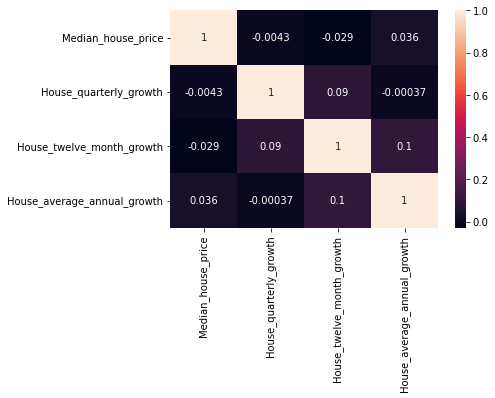

In [16]:
# Defining the correlation matrix
corrMat_reshape = reshape_data.corr()

# Applying the heatmap to the matrix with the seaborn library
sns.heatmap(corrMat_reshape, annot = True)

plt.show()

The `R-squared` value is coming up to around 0.0082. This can be considered as a relatively weak representation of the linearity. 

Additionally, if we take a look at the correlation matrix, the three features have almost no correlation with `House_quarterly_growth`. 

Let us look at a scatter plot of the target variable `House_quarterly_growth` with the other variables:

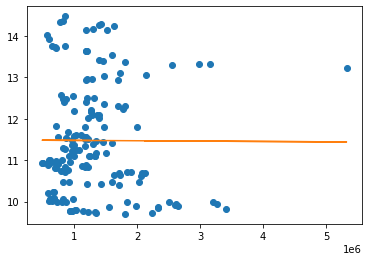

In [17]:
# Scatter plot of House_quarterly growth with Median_house_price

# Defining the x variable 
x = reshape_data['Median_house_price']

# Defining the y variabel
y = reshape_data['House_quarterly_growth']

# Plotting the scatter plot
plt.plot(x, y, 'o')

# Defining the slope and intercept of the linear regression line
m, b = np.polyfit(x, y, 1)

# Plotting the regression line 
plt.plot(x, m * x + b)

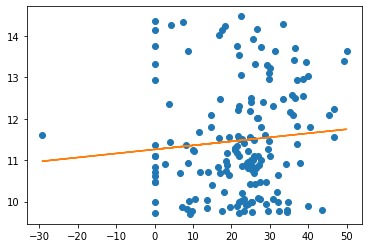

In [92]:
# Scatter plot of House_quarterly growth with House_twelve_month_growth

# Defining the x variable 
x = reshape_data['House_twelve_month_growth']

# Defining the y variable
y = reshape_data['House_quarterly_growth']

# Plotting the scatter plot
plt.plot(x, y, 'o')

# Defining the slope and intercept of the linear regression line
m, b = np.polyfit(x, y, 1)

# Plotting the regression line
plt.plot(x, m * x + b)

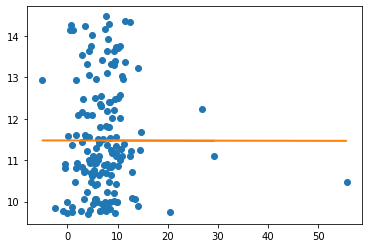

In [136]:
# Scatter plot of House_quarterly growth with House_average_annual_growth

# Defining the x variable 
x = reshape_data['House_average_annual_growth']

# Defining the y variable
y = reshape_data['House_quarterly_growth']

# Plotting the scatter plot
plt.plot(x, y, 'o')

# Defining the slope and intercept of the linear regression line
m, b = np.polyfit(x, y, 1)

# Plotting the regression line
plt.plot(x, m * x + b)

The scatter plots reinforce the lack of correlation between the predictors and `House_quarterly_growth`, suggesting weak linearity. We can now try to apply some scaling and transformation methods to the predictors and see if their linear relationship with `House_quarterly_growth` becomes stronger.

But what about outliers? Clearly we have a lot of them in the data. This can be shown with the help of a boxplot as follows:

<AxesSubplot:>

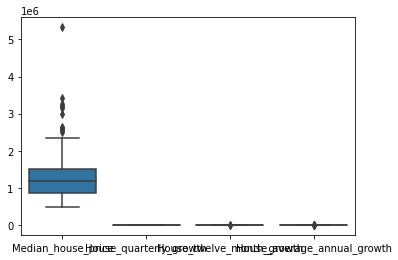

In [20]:
# Boxplot of the data
sns.boxplot(data = reshape_data)

The above plot is slightly cluttered but we can make out from it that only one column, `Median_house_price` has significant outliers. We can look at the outliers for `Median_house_price` more closely as follows:

<AxesSubplot:>

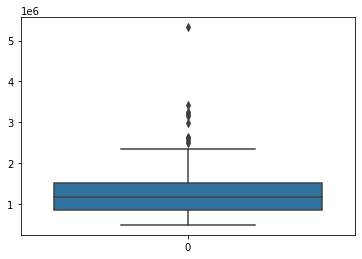

In [21]:
# Boxplot for Median_house_price
sns.boxplot(data = reshape_data['Median_house_price'])

This further reiterates the need to bring `Median_house_price` and the other columns on the same scale to reduce the outliers.

To see the extent of scaling differences between `Median_House_price` and the other features, we can divide its mean by the mean of the other columns.

In [22]:
# Ratio of means for Median_house_price and House_twelve_month_growth
reshape_data.Median_house_price.mean() / reshape_data["House_twelve_month_growth"].mean()

58795.42943938139

In [23]:
# Ratio of means for Median_house_price and House_average_annual_growth
reshape_data.Median_house_price.mean() / reshape_data["House_average_annual_growth"].mean()

178718.36306400842

Since both ratios indicate a very large difference of scale. We can try two different scaling methods to reduce this difference. They are the Standardization scale and the Min-Max scale.

### 4.3 Applying Scaling Methods

#### 4.3.1 Standardization

Standardization or Z-score normalisation is a scaling technique which rescales the features in such a way that they behave like a standard normal distribution. This rescaled distribution will have a mean $\mu=0$ and a standard deviation $\sigma=1$. The range of this scale is -1 to 1.

We can create an array of the standardized values and use it to create three new columns in the data. The goal is to compare these values with the original values.

In [130]:
# Fitting the standard scalar to the data
standard = preprocessing.StandardScaler().fit(reshape_data[['Median_house_price', 
                                                            'House_twelve_month_growth', 
                                                            'House_average_annual_growth']])

# Transforming the data with the standard scalar and creating a new array with it
reshape_standard = standard.transform(reshape_data[['Median_house_price', 
                                                    'House_twelve_month_growth', 
                                                    'House_average_annual_growth']]) 
reshape_standard[0:8]

array([[-7.20647773e-02, -1.79270272e+00,  3.79899264e+00],
       [-6.39185126e-01, -4.29456517e-01,  2.15834695e-01],
       [ 4.94307392e-01, -2.28907492e-01, -1.49581606e-01],
       [ 4.44179340e-01, -1.56446854e-03, -7.38404082e-01],
       [ 7.52429450e-01, -1.03516329e+00, -5.34048046e-01],
       [-4.06412223e-02, -2.02390741e-02,  3.68235806e-01],
       [ 7.50933090e-01,  1.39740707e+00,  7.35383938e-01],
       [-9.00210944e-02,  6.43115392e-01,  6.26278597e-01]])

In [25]:
# Adding the standardized values as columns to the dataframe
reshape_data['Median_house_price_standard'] = reshape_standard[:,0] 
reshape_data['House_twelve_month_growth_standard'] = reshape_standard[:,1] 
reshape_data['House_average_annual_growth_standard'] = reshape_standard[:,2] 
reshape_data.head()

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth,Median_house_price_standard,House_twelve_month_growth_standard,House_average_annual_growth_standard
0,1250000.0,11.11,0.00,29.20,-0.072065,-1.792703,3.798993
1,871000.0,11.53,16.79,8.51,-0.639185,-0.429457,0.215835
2,1628500.0,10.65,19.26,6.40,0.494307,-0.228907,-0.149582
3,1595000.0,13.54,22.06,3.00,0.444179,-0.001564,-0.738404
4,1801000.0,9.70,9.33,4.18,0.752429,-1.035163,-0.534048


In [26]:
# Describing these new values
reshape_data.describe()

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth,Median_house_price_standard,House_twelve_month_growth_standard,House_average_annual_growth_standard
count,1.640000e+02,164.000000,164.000000,164.000000,1.640000e+02,1.640000e+02,1.640000e+02
mean,1.298160e+06,11.475183,22.079268,7.263720,-8.123583e-17,7.582011e-17,2.166289e-17
std,6.703353e+05,1.336771,12.353913,5.791921,1.003063e+00,1.003063e+00,1.003063e+00
min,4.900000e+05,9.700000,-29.300000,-5.000000,-1.209298e+00,-4.171685e+00,-2.123869e+00
25%,8.500000e+05,10.450000,16.015000,4.507500,-6.706087e-01,-4.923818e-01,-4.773306e-01
50%,1.180500e+06,11.175000,24.150000,6.865000,-1.760618e-01,1.681309e-01,-6.905147e-02
75%,1.504250e+06,12.377500,29.472500,9.352500,3.083847e-01,6.002856e-01,3.617414e-01
max,5.325000e+06,14.480000,49.970000,55.590000,6.025601e+00,2.264558e+00,8.369294e+00


In [129]:
# Verifying the mean and standard deviation of the standardized values
print('Mean after standardisation:\nMedian_house_price = {:.2f}, \
House_twelve_month_growth = {:.2f}, House_average_annual_growth = {:.2f}'
      .format(reshape_standard[:,0].mean(), reshape_standard[:,1].mean(), reshape_standard[:,2].mean()))
print('\nStandard deviation after standardisation:\nMedian_house_price = {:.2f}, \
House_twelve_month_growth = {:.2f}, House_average_annual_growth = {:.2f}'
      .format(reshape_standard[:,0].std(), reshape_standard[:,1].std(), reshape_standard[:,2].std()))

Mean after standardisation:
Median_house_price = -0.00, House_twelve_month_growth = 0.00, House_average_annual_growth = 0.00

Standard deviation after standardisation:
Median_house_price = 1.00, House_twelve_month_growth = 1.00, House_average_annual_growth = 1.00


It looks like the standardization has been applied properly to the data. Let us also compare this standardized scale with the original scale.

(<AxesSubplot:>, <AxesSubplot:>)

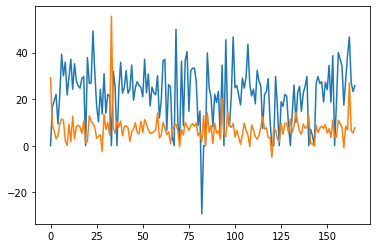

In [28]:
# Comparing the original scales for House_twelve_month_growth and House_average_annual_growth
reshape_data["House_twelve_month_growth"].plot(), reshape_data["House_average_annual_growth"].plot()

<AxesSubplot:>

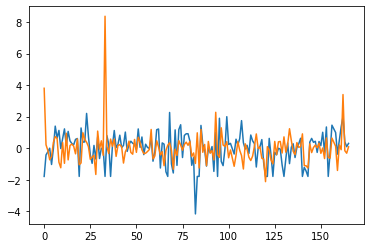

In [128]:
# Comparing the standardized scales for House_twelve_month_growth and House_average_annual_growth
reshape_data["House_twelve_month_growth_standard"].plot(), 
reshape_data["House_average_annual_growth_standard"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

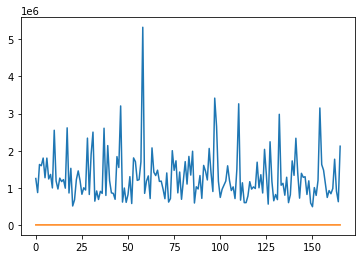

In [30]:
# Comparing the original scales for Median_house_price and House_twelve_month_growth
reshape_data["Median_house_price"].plot(), reshape_data["House_twelve_month_growth"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

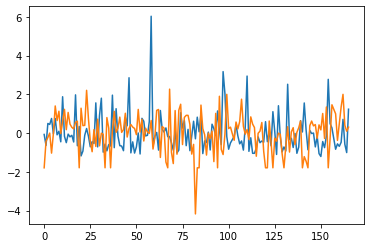

In [31]:
# Comparing the standardized scales for Median_house_price and House_twelve_month_growth
reshape_data["Median_house_price_standard"].plot(), reshape_data["House_twelve_month_growth_standard"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

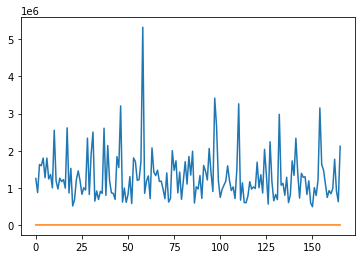

In [32]:
# Comparing the original scales for Median_house_price and House_average_annual_growth
reshape_data["Median_house_price"].plot(), reshape_data["House_average_annual_growth"].plot()

<AxesSubplot:>

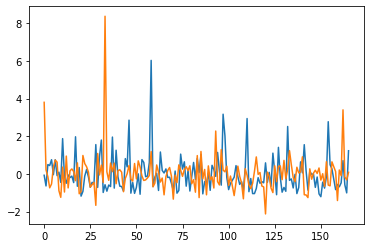

In [127]:
# Comparing the standardized scales for Median_house_price and House_average_annual_growth
reshape_data["Median_house_price_standard"].plot(), reshape_data["House_average_annual_growth_standard"].plot()

It looks like the standardization scale has infinitely improved the scale for the three columns. The only way to truly understand how good of a scale this is, we can compare it with the results of the MinMax Scaling.

#### 4.3.2 Applying the MinMax Scaling

The MinMax scaling technique rescales the given data in such a way that the range of the data falls between 0 and 1. We can use the `MinMaxScalar` from the `sklearn` library to do this. 

In [34]:
# Fitting the minmaxscaler to the data
minmax = preprocessing.MinMaxScaler().fit(reshape_data[['Median_house_price', 
                                                        'House_twelve_month_growth', 
                                                        'House_average_annual_growth']])

# Transforming the data into its minmax form and storing it in an array
reshape_minmax = minmax.transform(reshape_data[['Median_house_price', 
                                                'House_twelve_month_growth', 
                                                'House_average_annual_growth']])
reshape_minmax[0:8]

array([[0.15718718, 0.36962281, 0.56444958],
       [0.07880041, 0.58143055, 0.22297409],
       [0.23547053, 0.61258988, 0.18814986],
       [0.22854188, 0.6479122 , 0.13203499],
       [0.27114788, 0.48732181, 0.15151015],
       [0.16153051, 0.64501072, 0.23749794],
       [0.27094105, 0.86527059, 0.27248721],
       [0.15470527, 0.7480762 , 0.26208945]])

In [35]:
# Adding the minmaxed values as columns to the dataframe
reshape_data['Median_house_price_minmax'] = reshape_minmax[:,0]
reshape_data['House_twelve_month_growth_minmax'] = reshape_minmax[:,1] 
reshape_data['House_average_annual_growth_minmax'] = reshape_minmax[:,2] 
reshape_data.head()

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth,Median_house_price_standard,House_twelve_month_growth_standard,House_average_annual_growth_standard,Median_house_price_minmax,House_twelve_month_growth_minmax,House_average_annual_growth_minmax
0,1250000.0,11.11,0.00,29.20,-0.072065,-1.792703,3.798993,0.157187,0.369623,0.564450
1,871000.0,11.53,16.79,8.51,-0.639185,-0.429457,0.215835,0.078800,0.581431,0.222974
2,1628500.0,10.65,19.26,6.40,0.494307,-0.228907,-0.149582,0.235471,0.612590,0.188150
3,1595000.0,13.54,22.06,3.00,0.444179,-0.001564,-0.738404,0.228542,0.647912,0.132035
4,1801000.0,9.70,9.33,4.18,0.752429,-1.035163,-0.534048,0.271148,0.487322,0.151510


In [36]:
# Describing the data
reshape_data.describe()

,Median_house_price,House_quarterly_growth,House_twelve_month_growth,House_average_annual_growth,Median_house_price_standard,House_twelve_month_growth_standard,House_average_annual_growth_standard,Median_house_price_minmax,House_twelve_month_growth_minmax,House_average_annual_growth_minmax
count,1.640000e+02,164.000000,164.000000,164.000000,1.640000e+02,1.640000e+02,1.640000e+02,164.000000,164.000000,164.000000
mean,1.298160e+06,11.475183,22.079268,7.263720,-8.123583e-17,7.582011e-17,2.166289e-17,0.167148,0.648155,0.202405
std,6.703353e+05,1.336771,12.353913,5.791921,1.003063e+00,1.003063e+00,1.003063e+00,0.138642,0.155846,0.095592
min,4.900000e+05,9.700000,-29.300000,-5.000000,-1.209298e+00,-4.171685e+00,-2.123869e+00,0.000000,0.000000,0.000000
25%,8.500000e+05,10.450000,16.015000,4.507500,-6.706087e-01,-4.923818e-01,-4.773306e-01,0.074457,0.571654,0.156915
50%,1.180500e+06,11.175000,24.150000,6.865000,-1.760618e-01,1.681309e-01,-6.905147e-02,0.142813,0.674278,0.195824
75%,1.504250e+06,12.377500,29.472500,9.352500,3.083847e-01,6.002856e-01,3.617414e-01,0.209772,0.741422,0.236879
max,5.325000e+06,14.480000,49.970000,55.590000,6.025601e+00,2.264558e+00,8.369294e+00,1.000000,1.000000,1.000000


We now have our values with the minmax scale applied. As opposed to the standardized scale in which the values range from -1 to 1, the minmax scale has placed them in a range of 0 to 1. The same method of visualisation can be used to get a sense of its performance.

(<AxesSubplot:>, <AxesSubplot:>)

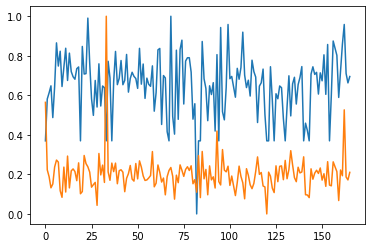

In [37]:
# Comparing the standardized scales for House_twelve_month_growth_minmax and House_average_annual_growth
reshape_data["House_twelve_month_growth_minmax"].plot(), reshape_data["House_average_annual_growth_minmax"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

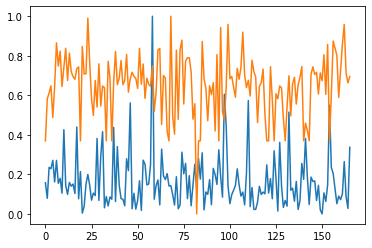

In [38]:
# Comparing the minmaxed scales for House_twelve_month_growth and Median_house_price
reshape_data["Median_house_price_minmax"].plot(), reshape_data["House_twelve_month_growth_minmax"].plot()

(<AxesSubplot:>, <AxesSubplot:>)

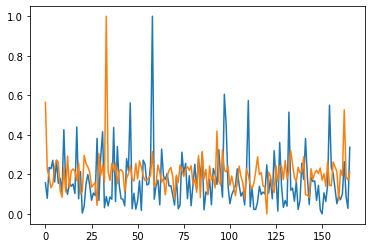

In [39]:
# Comparing the minmaxed scales for House_average_annual_growth and Median_house_price
reshape_data["Median_house_price_minmax"].plot(), reshape_data["House_average_annual_growth_minmax"].plot()

### 4.5 Which is the Better Scale?

Just by visually looking at the comparison of the scales, it is clear that overall, the standardization has scaled the data better than the minmax method. The bigger question is whether either or both of these scaling methods have improved the linearity between the three features and `House_quarterly_growth`. As was the case before, let us check the linearity with the help of the R-squared value and the correlation matrix.

In [40]:
# Creating a copy of the data with respect to the standardized data
reshape_standardized = reshape_data[['Median_house_price_standard', 'House_quarterly_growth', 
                                     'House_twelve_month_growth_standard',
                                     'House_average_annual_growth_standard']].copy()

In [41]:
# Creating a copy of the data with respect to the minmaxed data
reshape_minmaxed = reshape_data[['Median_house_price_minmax', 'House_quarterly_growth', 
                                 'House_twelve_month_growth_minmax','House_average_annual_growth_minmax']].copy()

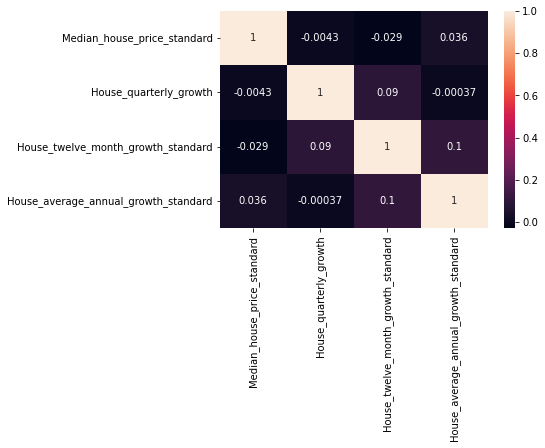

In [42]:
# Defining the correlation matrix for the standardized data
corrMat_reshape = reshape_standardized.corr()

# Applying the heatmap to the matrix with the seaborn library
sns.heatmap(corrMat_reshape, annot = True)

plt.show()

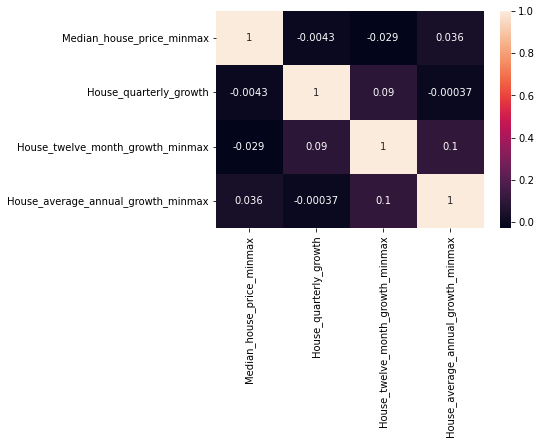

In [43]:
# Defining the correlation matrix for the minmaxed data
corrMat_reshape = reshape_minmaxed.corr()

# Applying the heatmap to the matrix with the seaborn library
sns.heatmap(corrMat_reshape, annot = True)

plt.show()

In [126]:
# R-squared value with respect to the standardized data
model1 = smf.ols(formula = 'House_quarterly_growth ~ Median_house_price_standard + \
                 House_twelve_month_growth_standard + House_average_annual_growth_standard', 
                 data = reshape_standardized)

model1_fit = model1.fit()


print('Parameters: ', model1_fit.params)
print('R2: ', model1_fit.rsquared)

Parameters:  Intercept                               11.475183
Median_house_price_standard             -0.001643
House_twelve_month_growth_standard       0.121410
House_average_annual_growth_standard    -0.013028
dtype: float64
R2:  0.008219137960478018


In [125]:
# R-squared values with respect to the minmaxed data
model1 = smf.ols(formula = 'House_quarterly_growth ~ Median_house_price_minmax + \
                 House_twelve_month_growth_minmax + House_average_annual_growth_minmax', 
                 data = reshape_minmaxed)

model1_fit = model1.fit()


print('Parameters: ', model1_fit.params)
print('R2: ', model1_fit.rsquared)

Parameters:  Intercept                             10.998357
Median_house_price_minmax             -0.011887
House_twelve_month_growth_minmax       0.781422
House_average_annual_growth_minmax    -0.136704
dtype: float64
R2:  0.008219137960478351


It looks like the R-squared values for the standardized data and the minmaxed data have not changed after scaling. The correlation matrix also shows that the correlation coefficient for the features has not changed with respect to `House_quarterly_growth`. 

Based on this, we can say that scaling may not be the only factor in terms of bringing more linearity to the relationship between the features and the target variable. We may have to apply further transformations on the data.  

### 4.6 Applying the Transformations

We may have to apply certain transformation methods to the the scaled data. Some of the types of transformation that we can perform here are:

* Root Transformation
* Log Transformation
* Power Transformation
* Box-cox Transformation

Given that we want to maintain the scaled data, we are limited in the types of tranformation we can use. 

* For example, we cannot use the Box-cox transformation on the scaled data as it does not accept non-positive values. Scaling between positive values does not make sense here as we have negative percentages from the original data. Changing them to positive values would discard the their meaning as it pertains to the suburban data.

* Secondly, we cannot use the root transformation or log transformation on the standardized scale even though it has scaled the values better than the Minmax Scaling. The standardized values are in the range [-1, 1]. Mathematically, the root and log of a number is undefined.

* However, we can apply the power transformation on the standardized values and the minmaxed values.


#### 4.6.1 Applying the Root Transformation

Let us start by applying the root transformation on the minmaxed values. As the name suggests, the root transformation calculates the square root of each value in the column. First let us observe what happens to the distribution of the data on applying the root transformation. We can use the `.sqrt()` function from the numpy library to do this.

In [122]:
# Applying the root transformation to the minmax scaled Median_house_price 
reshape_minmaxed['Median_house_price_minmax_sqrt'] \
= reshape_minmaxed['Median_house_price_minmax']**(1/2)

In [123]:
# Applying the root transformation to the minmax scaled House_twelve_month_growth 
reshape_minmaxed['House_twelve_month_growth_minmax_sqrt'] \
= reshape_minmaxed['House_twelve_month_growth_minmax']**(1/2)

In [124]:
# Applying the root transformation to the minmax scaled House_average_annual_growth
reshape_minmaxed['House_average_annual_growth_minmax_sqrt'] \
= reshape_minmaxed['House_average_annual_growth_minmax']**(1/2)

Let us look at the distribution of the columns with root transformation applied and compare it with the distribution of the columns before applying the root transformation.

1. **Median_house_price**

Text(0.5, 1.0, 'Square Root Transformed Data')

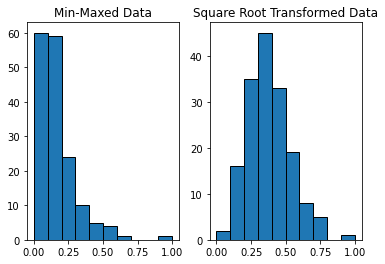

In [49]:
# Specifying the plot grid
fig, axs = plt.subplots(nrows = 1, ncols = 2)

# Defining the histograms for the pre-transformed and post transformed data
axs[0].hist(reshape_minmaxed['Median_house_price_minmax'], edgecolor = 'black')
axs[1].hist(reshape_minmaxed['Median_house_price_minmax_sqrt'], edgecolor = 'black')

# Adding the Plot labels
axs[0].set_title('Min-Maxed Data')
axs[1].set_title('Square Root Transformed Data')

2. **House_twelve_month_growth**

Text(0.5, 1.0, 'Square Root Transformed Data')

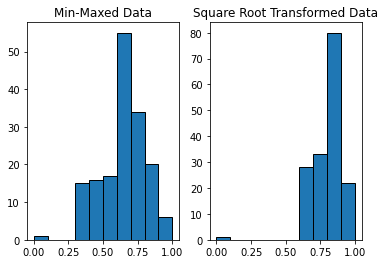

In [50]:
# Specifying the plot grid
fig, axs = plt.subplots(nrows = 1, ncols = 2)

# Defining the histograms for the pre-transformed and post transformed data
axs[0].hist(reshape_minmaxed['House_twelve_month_growth_minmax'], edgecolor = 'black')
axs[1].hist(reshape_minmaxed['House_twelve_month_growth_minmax_sqrt'], edgecolor = 'black')

# Adding the Plot labels
axs[0].set_title('Min-Maxed Data')
axs[1].set_title('Square Root Transformed Data')

3. **House_average_annual_growth**

Text(0.5, 1.0, 'Square Root Transformed Data')

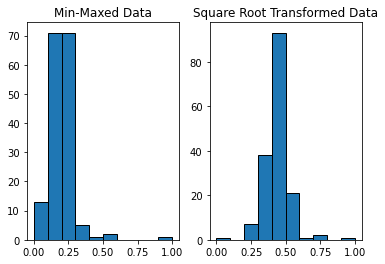

In [51]:
# Specifying the plot grid
fig, axs = plt.subplots(nrows = 1, ncols = 2)

# Defining the histograms for the pre-transformed and post transformed data
axs[0].hist(reshape_minmaxed['House_average_annual_growth_minmax'], edgecolor = 'black')
axs[1].hist(reshape_minmaxed['House_average_annual_growth_minmax_sqrt'], edgecolor = 'black')

# Adding the Plot labels
axs[0].set_title('Min-Maxed Data')
axs[1].set_title('Square Root Transformed Data')

The data for `Median_house_price` and `House_average_annual_growth` is slightly more normalised now after taking the root of that column. However, the root transformation has right skewed the data in `House_twelve_month_growth`. Let us measure the correlation coefficient of these transformed columns with respect to `House_quarterly_growth`.

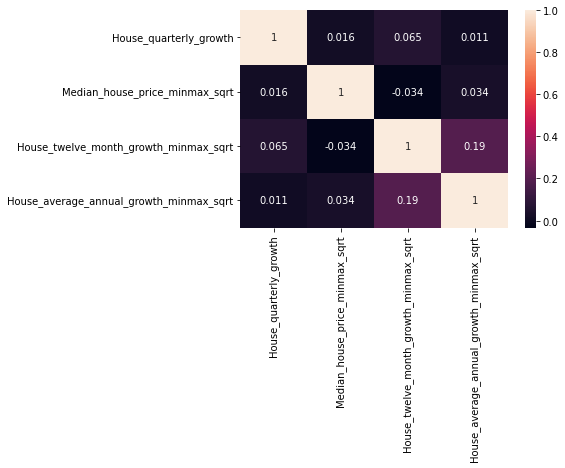

In [121]:
# Defining the correlation matrix for the minmaxed data
corrMat_reshape = reshape_minmaxed[['House_quarterly_growth',
                                    'Median_house_price_minmax_sqrt', 
                                    'House_twelve_month_growth_minmax_sqrt', 
                                    'House_average_annual_growth_minmax_sqrt']].corr()

# Applying the heatmap to the matrix with the seaborn library
sns.heatmap(corrMat_reshape, annot = True)

plt.show()

As expected the correlation between `House_quarterly_growth`, `Median_house_price` and `House_average_annual_growth` has improved. It is more of a positive correlation compared to what was experienced earlier with the original data and the minmaxed data. On the flipside, the correlation of `House_quarterly_growth` with `House_twelve_month_growth` has degraded.

Therefore, if root transformation with minmaxed scaling is finalised, the recommendation for the modeling activity would be to apply the root transformation on the minmaxed data for `Median_house_price` and `House_average_annual_growth` only.

Here is a brief demo of that model.

In [131]:
# Modeling the transformed data
model1 = smf.ols(formula = 'House_quarterly_growth ~ Median_house_price_minmax_sqrt + \
                 House_twelve_month_growth_minmax + House_average_annual_growth_minmax_sqrt'
                 , data = reshape_minmaxed)

# Fitting the model
model1_fit = model1.fit()

# Printing the R-squared value
print('Parameters: ', model1_fit.params)
print('R2: ', model1_fit.rsquared)

Parameters:  Intercept                                  10.949755
Median_house_price_minmax_sqrt              0.170756
House_twelve_month_growth_minmax            0.793965
House_average_annual_growth_minmax_sqrt    -0.122380
dtype: float64
R2:  0.008572270385507563


The R-squared value has increased from 0.00821 to 0.00857. This is a better score overall. However, if we were to use all the root transformed columns, the R-squared value becomes much worse than before. Here is a demonstration of that.

In [119]:
# Modeling the transformed data
model1 = smf.ols(formula = 'House_quarterly_growth ~ Median_house_price_minmax_sqrt + \
                 House_twelve_month_growth_minmax_sqrt + \
                 House_average_annual_growth_minmax_sqrt', data = reshape_minmaxed)

# Fitting the model
model1_fit = model1.fit()

# Printing the R-squared value
print('Parameters: ', model1_fit.params)
print('R2: ', model1_fit.rsquared)

Parameters:  Intercept                                  10.807580
Median_house_price_minmax_sqrt              0.161381
House_twelve_month_growth_minmax_sqrt       0.782207
House_average_annual_growth_minmax_sqrt    -0.038619
dtype: float64
R2:  0.004601595544564185


 Now, let us apply the log transformation on the minmaxed data and observe the results.

#### 4.6.2 Applying the Log Transformation

In simple mathematical terms, a logarithm is the power to be applied to a number to obtain another number. As mentioned earlier, we can only apply this transformation on the minmaxed data.

In [58]:
# Applying the root transformation to the minmax scaled Median_house_price 
reshape_minmaxed['Median_house_price_minmax_log'] \
= np.log(reshape_minmaxed['Median_house_price_minmax'])

In [59]:
# Applying the root transformation to the minmax scaled Median_house_price 
reshape_minmaxed['House_twelve_month_growth_minmax_log'] \
= np.log(reshape_minmaxed['House_twelve_month_growth_minmax'])

In [60]:
# Applying the root transformation to the minmax scaled Median_house_price 
reshape_minmaxed['House_average_annual_growth_minmax_log'] \
= np.log(reshape_minmaxed['House_average_annual_growth_minmax'])

Let us look at the distribution of the scaled columns with log applied. An important point to note here is that a log transformation can end up in an infinite range of values. This cannot be plotted. Therefore, we can use a try block as a precaution.

1. **Median_house_price**

Infinite range of values encountered


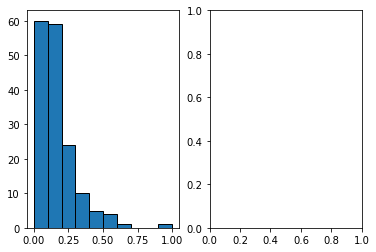

In [61]:
# Opening the try block
try: 
    # Specifying the plot grid
    fig, axs = plt.subplots(nrows = 1, ncols = 2)

    # Defining the histograms for the pre-transformed and post transformed data
    axs[0].hist(reshape_minmaxed['Median_house_price_minmax'], edgecolor = 'black')
    axs[1].hist(reshape_minmaxed['Median_house_price_minmax_log'], edgecolor = 'black')

    # Adding the Plot labels
    axs[0].set_title('Min-Maxed Data')
    axs[1].set_title('Log Transformed Data')

# Capturing the exception
except ValueError as e:
    
    print('Infinite range of values encountered')

As feared, the log transformation for `Median_house_price` has ended up in an infinite range of values. Let us check if this is the same case with the other two column transformations.

2. **House_twelve_month_growth**

Infinite range of values encountered


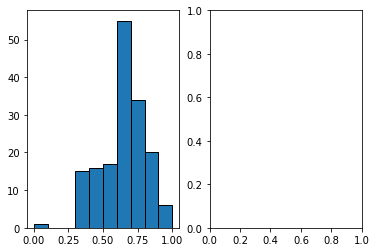

In [62]:
# Opening the try block
try: 
    # Specifying the plot grid
    fig, axs = plt.subplots(nrows = 1, ncols = 2)

    # Defining the histograms for the pre-transformed and post transformed data
    axs[0].hist(reshape_minmaxed['House_twelve_month_growth_minmax'], edgecolor = 'black')
    axs[1].hist(reshape_minmaxed['House_twelve_month_growth_minmax_log'], edgecolor = 'black')

    # Adding the Plot labels
    axs[0].set_title('Min-Maxed Data')
    axs[1].set_title('Log Transformed Data')

# Capturing the exception
except ValueError as e:
    
    print('Infinite range of values encountered')

Infinite range of values encountered


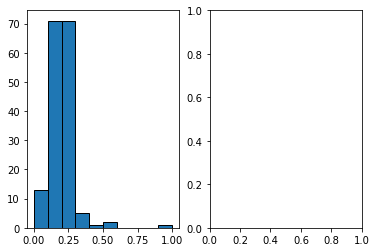

In [63]:
# Opening the try block
try: 
    # Specifying the plot grid
    fig, axs = plt.subplots(nrows = 1, ncols = 2)

    # Defining the histograms for the pre-transformed and post transformed data
    axs[0].hist(reshape_minmaxed['House_average_annual_growth_minmax'], edgecolor = 'black')
    axs[1].hist(reshape_minmaxed['House_average_annual_growth_minmax_log'], edgecolor = 'black')

    # Adding the Plot labels
    axs[0].set_title('Min-Maxed Data')
    axs[1].set_title('Log Transformed Data')

# Capturing the exception
except ValueError as e:
    
    print('Infinite range of values encountered')

As we are dealing with infinite values here, they cannot be plotted or handled. Therefore, this completely discounts the use of the log transformation for the data. Therefore, we can move on to the power transformation now.

#### 4.6.3 Applying the Power Transformation

The power of a numeric value is the number of times a number is multiplied to itself to obtain a new value. To apply the power to a value, we can apply this transformation on negative as well as positive values. Therefore, we can apply this to the standardized version of the original data and the minmaxed version. Let us start with the standardized version. 

For the power transformation let us square the values by 2. If this does not give us the desired result, squaring these values by a power greater than 2 would not drastically improve the linearity from there.

In [83]:
# Performing the power transformation on the standardized data for Median_house_price
reshape_standardized['Median_house_price_standard_power'] \
= reshape_standardized['Median_house_price_standard']**2

In [84]:
# Performing the power transformation on the standardized data for House_twelve_month_growth
reshape_standardized['House_twelve_month_growth_standard_power'] \
= reshape_standardized['House_twelve_month_growth_standard']**2

In [85]:
# Performing the power transformation on the standardized data for House_average_annual_growth
reshape_standardized['House_average_annual_growth_standard_power'] \
= reshape_standardized['House_average_annual_growth_standard']**2

Now, we can observe the distribution of the transformed data.

1. **Median_house_price**

Text(0.5, 1.0, 'Power Transformed Data')

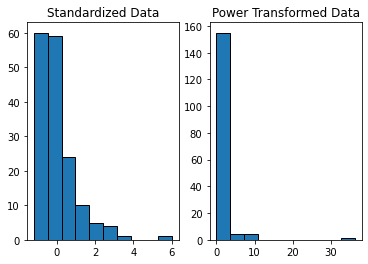

In [86]:
# Specifying the plot grid
fig, axs = plt.subplots(nrows = 1, ncols = 2)

# Defining the histograms for the pre-transformed and post transformed data
axs[0].hist(reshape_standardized['Median_house_price_standard'], edgecolor = 'black')
axs[1].hist(reshape_standardized['Median_house_price_standard_power'], edgecolor = 'black')

# Adding the Plot labels
axs[0].set_title('Standardized Data')
axs[1].set_title('Power Transformed Data')

2. **House_twelve_month_growth**

Text(0.5, 1.0, 'Power Transformed Data')

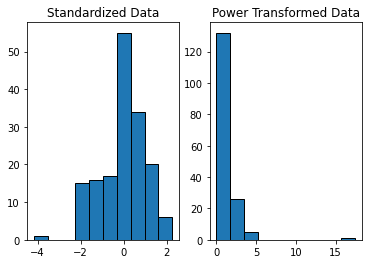

In [87]:
# Specifying the plot grid
fig, axs = plt.subplots(nrows = 1, ncols = 2)

# Defining the histograms for the pre-transformed and post transformed data
axs[0].hist(reshape_standardized['House_twelve_month_growth_standard'], edgecolor = 'black')
axs[1].hist(reshape_standardized['House_twelve_month_growth_standard_power'], edgecolor = 'black')

# Adding the Plot labels
axs[0].set_title('Standardized Data')
axs[1].set_title('Power Transformed Data')

3. **House_average_annual_growth**

Text(0.5, 1.0, 'Power Transformed Data')

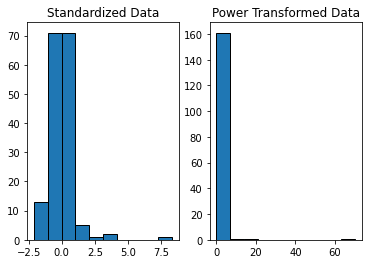

In [88]:
# Specifying the plot grid
fig, axs = plt.subplots(nrows = 1, ncols = 2)

# Defining the histograms for the pre-transformed and post transformed data
axs[0].hist(reshape_standardized['House_average_annual_growth_standard'], edgecolor = 'black')
axs[1].hist(reshape_standardized['House_average_annual_growth_standard_power'], edgecolor = 'black')

# Adding the Plot labels
axs[0].set_title('Standardized Data')
axs[1].set_title('Power Transformed Data')

In the case of the standardized scale, the power transformation has horribly skewed the data to the left. Let us visualise what this means for us in terms of the correlation between the target variable `House_quarterly_growth` and the three features.

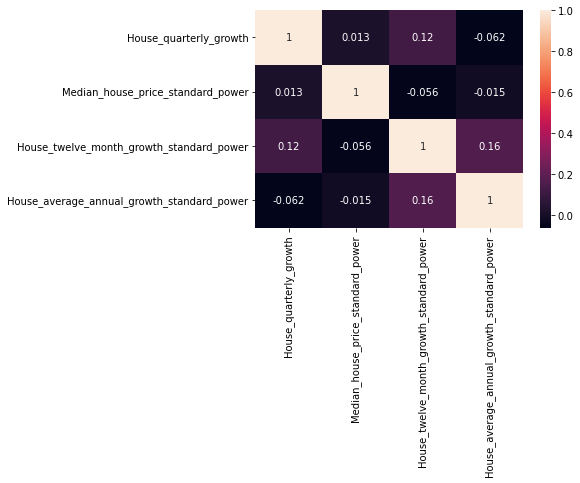

In [117]:
# Defining the correlation matrix for the minmaxed data
corrMat_reshape = reshape_standardized[['House_quarterly_growth'
                                        , 'Median_house_price_standard_power'
                                        , 'House_twelve_month_growth_standard_power'
                                        , 'House_average_annual_growth_standard_power']].corr()

# Applying the heatmap to the matrix with the seaborn library
sns.heatmap(corrMat_reshape, annot = True)

plt.show()

The correlation has improved between `House_quarterly_growth` and `House_twelve_month_growth` even though the data seems to be more left skewed for the latter. As far as `Median_house_price` and `House_average_annual_growth` are concerned, their correlation with `House_quarterly_growth` has become worse.

This can be further illustrated with a scatter plot. For example, if we were to plot `House_quarterly_growth` against the transformed value of `House_average_annual_growth`, the relationship depicted would be far away from the desired linearity, indicating a severe left skew of the data.

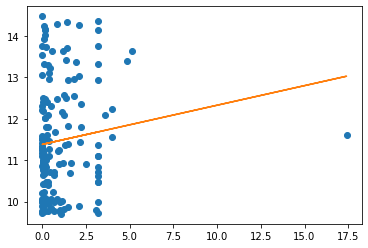

In [93]:
# Scatter plot of House_quarterly growth with the transformed House_twelve_month_growth

# Defining the x variable 
x = reshape_standardized['House_twelve_month_growth_standard_power']

# Defining the y variable
y = reshape_standardized['House_quarterly_growth']

# Plotting the scatter plot
plt.plot(x, y, 'o')

# Defining the slope and intercept of the linear regression line
m, b = np.polyfit(x, y, 1)

# Plotting the regression line
plt.plot(x, m * x + b)

Although we know that skewed data is not what we want, let us look at the R-Squared value we get from using the transformed and standardized data.

In [116]:
# Modeling the transformed data
model1 = smf.ols(formula = 'House_quarterly_growth ~ Median_house_price_standard_power + \
                 House_twelve_month_growth_standard_power + House_average_annual_growth_standard_power'
                 , data = reshape_standardized)

# Fitting the model
model1_fit = model1.fit()

# Printing the R-squared value
print('Parameters: ', model1_fit.params)
print('R-Squared: ', model1_fit.rsquared)

Parameters:  Intercept                                     11.380736
Median_house_price_standard_power              0.008324
House_twelve_month_growth_standard_power       0.105920
House_average_annual_growth_standard_power    -0.019797
dtype: float64
R-Squared:  0.02240730416541148


The R-squared value has significantly improved as compared to the R-squared value of 0.00861 which was achieved with the root transformation on the minmaxed data.

However, as mentioned earlier, this model is based on data which is severely skewed and outlier heavy. Therefore, it may not be a good predictor for unknown data. Since we cannot rely on the skew, let us rely on the results of the correlation matrix. 

By the results of the correlation coefficient, there is an improvement in the correlation between `House_quarterly_growth` and the transformed `House_twelve_month_growth`. So, we can try modeling the data with the transformed version of `House_twelve_month_growth` while leaving the standardized versions of the other columns intact.

In [115]:
# Modeling the transformed data
model1 = smf.ols(formula = 'House_quarterly_growth ~ Median_house_price_standard + \
                 House_twelve_month_growth_standard_power + House_average_annual_growth_standard'
                 , data = reshape_standardized)

# Fitting the model
model1_fit = model1.fit()

# Printing the R-squared value
print('Parameters: ', model1_fit.params)
print('R-Squared: ', model1_fit.rsquared)

Parameters:  Intercept                                   11.379800
Median_house_price_standard                 -0.010592
House_twelve_month_growth_standard_power     0.095383
House_average_annual_growth_standard        -0.010928
dtype: float64
R-Squared:  0.015327618957839517


The R-squared value is weaker compared to using the power transformed version of all the input features. Just in terms of comparing these two models, this is still a better model than the previous one despite the lower R-squared value. 

However, we still need to find a better transformation because skewed data suggests more outliers and less linearity overall.

Let us hope for better results when we use the power transformation on the minmaxed data.

In [97]:
# Performing the power transformation on the standardized data for House_average_annual_growth
reshape_minmaxed['Median_house_price_minmax_power'] \
= reshape_minmaxed['Median_house_price_minmax']**2

In [98]:
# Performing the power transformation on the standardized data for House_average_annual_growth
reshape_minmaxed['House_twelve_month_growth_minmax_power'] \
= reshape_minmaxed['House_twelve_month_growth_minmax']**2

In [99]:
# Performing the power transformation on the standardized data for House_average_annual_growth
reshape_minmaxed['House_average_annual_growth_minmax_power'] \
= reshape_minmaxed['House_average_annual_growth_minmax']**2

Following the same drill, let us compare the distribution of the power transformed minmax data.

1. **Median_house_price**

Text(0.5, 1.0, 'Power Transformed Data')

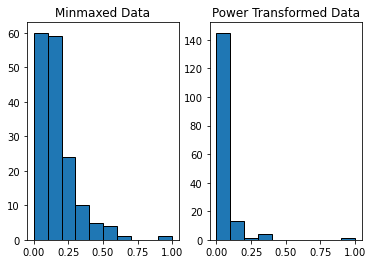

In [75]:
# Specifying the plot grid
fig, axs = plt.subplots(nrows = 1, ncols = 2)

# Defining the histograms for the pre-transformed and post transformed data
axs[0].hist(reshape_minmaxed['Median_house_price_minmax'], edgecolor = 'black')
axs[1].hist(reshape_minmaxed['Median_house_price_minmax_power'], edgecolor = 'black')

# Adding the Plot labels
axs[0].set_title('Minmaxed Data')
axs[1].set_title('Power Transformed Data')

2. **House_twelve_month_growth**

Text(0.5, 1.0, 'Power Transformed Data')

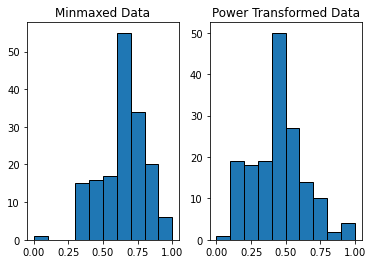

In [100]:
# Specifying the plot grid
fig, axs = plt.subplots(nrows = 1, ncols = 2)

# Defining the histograms for the pre-transformed and post transformed data
axs[0].hist(reshape_minmaxed['House_twelve_month_growth_minmax'], edgecolor = 'black')
axs[1].hist(reshape_minmaxed['House_twelve_month_growth_minmax_power'], edgecolor = 'black')

# Adding the Plot labels
axs[0].set_title('Minmaxed Data')
axs[1].set_title('Power Transformed Data')

3. **House_average_annual_growth**

Text(0.5, 1.0, 'Power Transformed Data')

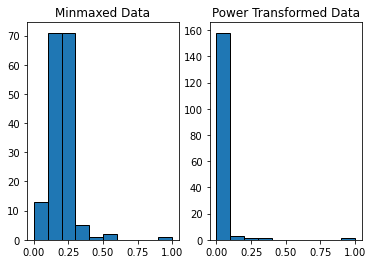

In [101]:
# Specifying the plot grid
fig, axs = plt.subplots(nrows = 1, ncols = 2)

# Defining the histograms for the pre-transformed and post transformed data
axs[0].hist(reshape_minmaxed['House_average_annual_growth_minmax'], edgecolor = 'black')
axs[1].hist(reshape_minmaxed['House_average_annual_growth_minmax_power'], edgecolor = 'black')

# Adding the Plot labels
axs[0].set_title('Minmaxed Data')
axs[1].set_title('Power Transformed Data')

We have mostly achieved similar results by power transforming the minmaxed data with the exception being `House_twelve_month_growth`. It appears to be less skewed than before. The other two features are more left skewed after the transformation. What about the correlation between the variables? Let us have a look at that now.

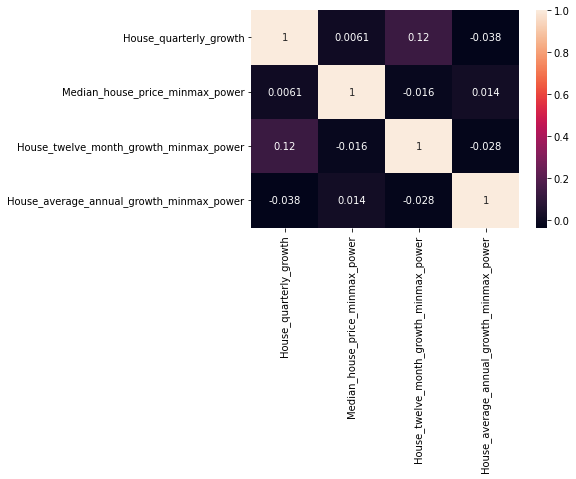

In [118]:
# Defining the correlation matrix for the minmaxed data
corrMat_reshape = reshape_minmaxed[['House_quarterly_growth',
                                    'Median_house_price_minmax_power', 
                                    'House_twelve_month_growth_minmax_power', 
                                    'House_average_annual_growth_minmax_power']].corr()

# Applying the heatmap to the matrix with the seaborn library
sns.heatmap(corrMat_reshape, annot = True)

plt.show()

For `House_twelve_month_growth`, the improvement in the correlation with `House_quarterly_growth` is the same as what we previously observed for the standardized values of `House_twelve_month_growth`. The transformations of `Median_house_price` and `House_average_annual_growth` have worsened their correlation with `House_quarterly_growth`.

Given these observations, we can expect an improved R-squared value. Let us observed the R-squared value with the power transformed values of `House_twelve_month_growth` with the pre-transformed versions of `Median_house_price` and `House_average_annual_growth`.

In [113]:
# Modeling the transformed data
model1 = smf.ols(formula = 'House_quarterly_growth ~ Median_house_price_minmax_power + \
                 House_twelve_month_growth_minmax_power + House_average_annual_growth_minmax'
                 , data = reshape_minmaxed)

# Fitting the model
model1_fit = model1.fit()

# Printing the R-squared value
print('Parameters: ', model1_fit.params)
print('R2: ', model1_fit.rsquared)

Parameters:  Intercept                                 11.131749
Median_house_price_minmax_power            0.123324
House_twelve_month_growth_minmax_power     0.863471
House_average_annual_growth_minmax        -0.227070
dtype: float64
R2:  0.01516395395184289


We are getting a significantly better R-squared value compared to the simple minmaxed version of these variables, a 0.015 versus 0.00821.

If we recall, we previously achieved an R-squared value of around 0.015 by applying the power transformation on the standardized data where we used the transformed values for `House_twelve_month_growth` only due to its improved correlation. 

However, this model is better because unlike the power transformation of the standardized data, the transformed distribution of `House_twelve_month_growth` is more normalised and less skewed. In fact, the skewness has been reduced by applying the power transformation on the minmaxed data.

For the sake of comparison, we can observe the R-squared value for the model made up of all the power transformed minmaxed columns.

In [112]:
# Modeling the transformed data
model1 = smf.ols(formula = 'House_quarterly_growth ~ Median_house_price_minmax_power + \
                 House_twelve_month_growth_minmax_power + House_average_annual_growth_minmax_power'
                 , data = reshape_minmaxed)

# Fitting the model
model1_fit = model1.fit()

# Printing the R-squared value
print('Parameters: ', model1_fit.params)
print('R2: ', model1_fit.rsquared)

Parameters:  Intercept                                   11.123327
Median_house_price_minmax_power              0.115792
House_twelve_month_growth_minmax_power       0.842726
House_average_annual_growth_minmax_power    -0.558808
dtype: float64
R2:  0.01612190347129472


We do have a slightly better R-squared value but we must dismiss this model because the power transformations have made the distributions of `Median_house_price` and `House_average_annual_growth` more left skewed.

### 4.7 Summarising the Findings

We did a lot of tweaking and adjusting in the data reshaping process. Here are the final conclusions we can draw from it.

* The original data presented a relatively low linearity between `House_quarterly_growth` and the input feature. This was highlighted through the correlation matrix and an R-squared value of 0.00821.<br><br>
* We applied two different scaling techniques on the data and compared the result. The standardization scaler scaled the values in the range [-1, 1] and the min-max scaler scaled the values in the range [0,1].<br><br>
* The Standardized scalar scaled the input features better than the MinMax Scaler.<br><br>
* Both scaling techniques scaled the data well overall but they did not improve the linearity between the target variable and the input attributes.<br><br>
* Transformations to be applied on the scaled data were:
     * Root Transformation
     * Log Transformation
     * Power Transformation <br><br>
* The Box-cox transformation could not be applied here as it operates on positive values only.<br><br>
* The Root transformation was only applied to the minmaxed data as it cannot accept negative values.<br><br>
* For the minmaxed values, the root transformation reduced the left skewness in `Median_house_price`. On the flipside, it increased the skewness in `House_twelve_month_growth` and `House_average_annual_growth`. It had the same effect on the correlation of these three variables with `House_quarterly_growth`.<br><br>
* Given this observation, we tried to generate the R-squared value with the transformed values of `Median_house_price` while using the existing minmaxed values of the other two columns. We got an R-squared value of around 0.00861, which is a significant improvement from the previous value of 0.00821.<br><br>
* We tried applying the `log transformation` on the `minmaxed data` only as the logarithm of negative values is undefined.<br><br>
* The `log transformation` of the minmaxed values resulted in infinite values. Therefore, we had to dismiss the log transformation method.<br><br>
* With the `power transformation`, the benefit was that we could apply this to the standardized values as well as the minmaxed values.<br><br>
* We observed that the power transformation made the standardized values more left skewed, even though it improved the correlation coefficient of `House_twelve_month_growth` with `House_quarterly_growth`. Furthermore, the R-squared value of the fully transformed model was the best on yet at 0.022. Despite this, it was an unacceptable outcome.<br><br>
* Now, combining the transformed `House_twelve_month_growth` with the existing standardized columns into a model gave us a lower R-squared value of 0.015 but in comparison with the model of the fully power transformed data, this is preferred. <br><br>
* Despite these findings and an improved R-squared value from the root transformation, the skewness of this transformation makes it undesirable in the end.<br><br>
* Applying the power transformation on the minmaxed data created a left skew in the distribution for `Median_house_price` and `House_average_annual_growth` but it improved the normality of `House_twelve_month_growth`. The improvement in correlation between `House_quarterly_growth` and the power transformed minmaxed `House_twelve_month_growth` was the same as that of the power transformed standardized values. Similarly, the R-squared value was the same as well standing at 0.015.

In conclusion, there are two contenders for the most optimum linearity between the input features and `House_quarterly_growth`:

1. R-squared Value = 0.015
   * Applying the Min-Max Scaling.
   * Applying power transformation on the minmaxed values of `House_twelve_month_growth`.<br><br>
2. R-squared Value = 0.00857
   * Applying the Min-Max Scaling
   * Applying the root transformation on the minmaxed values of `Median_house_price` and `House_average_annual_growth`.

### 4.8 Additonal Feature Engineering Techniques

Although we have seen the potential of promising results with the application of scaling and transformation techniques, there is scope for improvement beyond the scope of these techniques.

There is a lot of potential to improve the linear relationship. There are a number of other techniques which could also be applied to the data to improve the linearity of the target variable `House_quarterly_growth` with respect to the features `Median_house_growth`, `House_twelve_month_growth` and `House_average_annual_growth`.

For example, multivariate outlier analysis and removal is one of the techniques which can be applied to the data. For example, outlier removal can be applied on the power transformed minmax data. Other techniques like k-folds cross validation can be used to determine the importance of the input features with respect to the target variable.

## 5. Summary

In this activity, we have performed the following tasks:

* Imported data from the PDF and XML files.
* Combined the data acquired from both files and removed duplicates
* Linked this dataset to the suburbs shapefile to acquire the suburb for each of the properties.
* Used the metropolitan data to find the closest station from each property by calculating the Haversine distance.
* Found the set of direct services running from the closest station of each property to Melbourne Central Station on weekdays between 7:00 am to 9:00 am.
* Calculated the travel time from the closest station of each property to Melbourne Central Station.
* Web scraped Suburb Housing Data from https://www.yourinvestmentpropertymag.com.au with the help of Selenium.
* Performed different Scaling and Transformation techniques on the data and observed the results.

## 6. References:

* Rockikz, A. (n.d.). How to Extract Tables from PDF in Python - Python Code. Www.thepythoncode.com. Retrieved May 11, 2022, from https://www.thepythoncode.com/article/extract-pdf-tables-in-python-camelot
* Kite. (n.d.). Www.adamsmith.haus. Retrieved June 6, 2022, from https://www.adamsmith.haus/python/answers/how-to-print-the-first-n-lines-of-a-file-in-python
* Convert XML structure to DataFrame using BeautifulSoup - Python. (2021, February 23). GeeksforGeeks. https://www.geeksforgeeks.org/convert-xml-structure-to-dataframe-using-beautifulsoup-python/
* Spatial Joins — GeoPandas 0.10.2+0.g04d377f.dirty documentation. (n.d.). Geopandas.org. Retrieved May 24, 2022, from https://geopandas.org/en/stable/gallery/spatial_joins.html
* Postcode for Golden Point, Ballarat, Victoria - Postcodes Australia. (n.d.). Postcodes-Australia.com. Retrieved June 6, 2022, from https://postcodes-australia.com/areas/vic/country+victoria/golden+point
* Program for distance between two points on earth. (2017, December 24). GeeksforGeeks. https://www.geeksforgeeks.org/program-distance-two-points-earth/
* ChromeDriver - WebDriver for Chrome - Downloads. (n.d.). Chromedriver.chromium.org. https://chromedriver.chromium.org/downloads
* Python | Box-Cox Transformation. (2020, June 5). GeeksforGeeks. https://www.geeksforgeeks.org/box-cox-transformation-using-python/
* Normalize A Column In Pandas. (2020, December 9). GeeksforGeeks. https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
* Vidiyala, R. (2020, June 28). Normalization vs Standardization. Medium. https://towardsdatascience.com/normalization-vs-standardization-cb8fe15082eb#:~:text=Standardization%20(also%20called%2C%20Z%2D
* Checking XML Well-Formedness - Python Cookbook [Book]. (n.d.). Www.oreilly.com. Retrieved June 3, 2022, from https://www.oreilly.com/library/view/python-cookbook/0596001673/ch12s02.html
* General Transit Feed Specification. (2022, May 10). Wikipedia. https://en.wikipedia.org/wiki/General_Transit_Feed_Specification#/media/File:GTFS_class_diagram.svg
* What is a Logarithm? (2019). Umn.edu. http://www.mclph.umn.edu/mathrefresh/logs.html